# Промышленность — задача проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

## Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## Задача

- Предсказать оптимальную температуру нагрева стали
- Метрика качества - MAE со значением от 6.8 и менее
- Random_state = 270323

# План проекта

### Загрузка и исследовательский анализ данных: 

- Загрузка и вывод описания данных
- Знакомство с распределением данных по датасетам
- Проверка адекватности данных

### Предобработка данных 

- Выявление и работа с аномалиями в данных
- Выявление и работа с ошибками в данных
- Выявление и обработка пропусков в данных

### Подготовка данных 

- Определение призанков необходимых для обучения модели
- Создание синтетических признаков при необходимости
- Удаление данных непригодных к обучению модели при необходимости
- Объединение данных в одну таблицу по полю key

### Подготовка признаков

- Выделение обучающего и целевого признака
- Разделение данных на выборки обучающую и тестовую в формате 3:1
- Кодирование признаков при необходимости

### Обучение модели

- Подбор гиперпараметров на разных моделях
- Выбор модели для проведения тестирования при помощи кросс-валидации
- Проверка адекватности выбранной модели при помощи константной модели

### Отчет

- Формирование отчета о проделанной работе
- Формулировка выводов

## 1 Загрузка и исследовательский анализ данных

Загрузим данные и подготовим список ключей для работы с ними.

In [1]:
pip install probscale

In [2]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
#plt.style.use('seaborn-pastel')
import seaborn as sns
import probscale

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn import tree
from sklearn import ensemble
from sklearn.neighbors import KNeighborsRegressor

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from catboost import Pool

import shap
import time

import warnings
warnings.filterwarnings('ignore')

In [4]:
STATE = 270323

In [6]:
try:
    data_arc = pd.read_csv('data_arc.csv')
    data_bulk = pd.read_csv('data_bulk.csv')
    data_bulk_time = pd.read_csv('data_bulk_time.csv')
    data_gas = pd.read_csv('data_gas.csv')
    data_temp = pd.read_csv('data_temp.csv')
    data_wire = pd.read_csv('data_wire.csv')
    data_wire_time = pd.read_csv('data_wire_time.csv')
except:
    try:
        data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
        data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
        data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
        data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
        data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
        data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
        data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
    except:
        data_arc = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/final_steel/data_arc.csv')
        data_bulk = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/final_steel/data_bulk.csv')
        data_bulk_time = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/final_steel/data_bulk_time.csv')
        data_gas = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/final_steel/data_gas.csv')
        data_temp = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/final_steel/data_temp.csv')
        data_wire = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/final_steel/data_wire.csv')
        data_wire_time = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/final_steel/data_wire_time.csv')

In [7]:
datas_list = {
    'Данные об электродах':data_arc, 
    'Данные о подаче сыпучих материалов (объём)':data_bulk, 
    'Данные о подаче сыпучих материалов (время)':data_bulk_time,
    'Данные о продувке сплава газом':data_gas,
    'Результаты измерения температуры':data_temp,
    'Данные о проволочных материалах (объём)':data_wire,
    'Данные о проволочных материалах (время)':data_wire_time
}

def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [8]:
for data in datas_list:
    print(data)
    display(datas_list[data].tail(15))
    display(datas_list[data].info())
    print('**********')

Данные об электродах


key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
14861  3239  2019-09-01 01:43:37  2019-09-01 01:45:48           0.486958   
14862  3239  2019-09-01 01:52:51  2019-09-01 01:57:45           1.156764   
14863  3239  2019-09-01 02:07:01  2019-09-01 02:07:54           0.205792   
14864  3239  2019-09-01 02:09:28  2019-09-01 02:11:19           0.434492   
14865  3239  2019-09-01 02:13:38  2019-09-01 02:15:43           0.488352   
14866  3240  2019-09-01 02:35:24  2019-09-01 02:37:25           0.411601   
14867  3240  2019-09-01 02:40:55  2019-09-01 02:43:28           0.521811   
14868  3240  2019-09-01 03:08:38  2019-09-01 03:11:08           0.518065   
14869  3240  2019-09-01 03:12:34  2019-09-01 03:17:08           0.983723   
14870  3240  2019-09-01 03:31:47  2019-09-01 03:34:08           0.548882   
14871  3241  2019-09-01 03:58:58  2019-09-01 04:01:35           0.533670   
14872  3241  2019-09-01 04:05:04  2019-09-01 04:08:04           0.676604   
14873  3241  2019-09-01 04:16:41  2019-09-01 04:19:45           0.733899   
14874  3241  2019-09-01 04:31:51  2019-09-01 04:32:48           0.220694   
14875  3241  2019-09-01 04:34:47  2019-09-01 04:36:08           0.306580   

       Реактивная мощность  
14861             0.315940  
14862             0.725063  
14863             0.135075  
14864             0.277050  
14865             0.317727  
14866             0.274390  
14867             0.378517  
14868             0.528780  
14869             0.884585  
14870             0.416994  
14871             0.354439  
14872             0.523631  
14873             0.475654  
14874             0.145768  
14875             0.196708

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

**********
Данные о подаче сыпучих материалов (объём)


key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
3114  3227     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3115  3228     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3116  3229     NaN     NaN    70.0     NaN     NaN     NaN     NaN     NaN   
3117  3230     NaN     NaN   132.0     NaN     NaN     NaN     NaN     NaN   
3118  3231     NaN     NaN   114.0     NaN     NaN     NaN     NaN     NaN   
3119  3232     NaN     NaN    22.0     NaN     NaN     NaN     NaN     NaN   
3120  3233     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3121  3234     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3122  3235     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3123  3236     NaN     NaN    42.0     NaN     NaN     NaN     NaN     NaN   
3124  3237     NaN     NaN   170.0     NaN     NaN     NaN     NaN     NaN   
3125  3238     NaN     NaN   126.0     NaN     NaN     NaN     NaN     NaN   
3126  3239     NaN     NaN     NaN     NaN     NaN   114.0     NaN     NaN   
3127  3240     NaN     NaN     NaN     NaN     NaN    26.0     NaN     NaN   
3128  3241     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

      Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
3114     NaN      NaN      NaN    208.0      NaN    130.0    202.0  
3115     NaN      NaN      NaN    310.0      NaN    120.0    204.0  
3116     NaN      NaN      NaN    256.0      NaN    128.0    206.0  
3117     NaN      NaN      NaN    254.0      NaN    130.0    204.0  
3118     NaN      NaN      NaN    258.0      NaN    130.0    204.0  
3119     NaN      NaN      NaN    252.0      NaN     92.0    204.0  
3120     NaN      NaN      NaN    254.0      NaN    114.0    204.0  
3121     NaN      NaN      NaN      NaN      NaN    262.0    204.0  
3122     NaN      NaN      NaN    204.0      NaN    118.0    206.0  
3123     NaN      NaN      NaN    258.0      NaN    132.0    208.0  
3124     NaN      NaN      NaN    252.0      NaN    130.0    206.0  
3125     NaN      NaN      NaN    254.0      NaN    108.0    106.0  
3126     NaN      NaN      NaN    158.0      NaN    270.0     88.0  
3127     NaN      NaN      NaN      NaN      NaN    192.0     54.0  
3128     NaN      NaN      NaN      NaN      NaN    180.0     52.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

**********
Данные о подаче сыпучих материалов (время)


key Bulk 1 Bulk 2               Bulk 3 Bulk 4 Bulk 5  \
3114  3227    NaN    NaN                  NaN    NaN    NaN   
3115  3228    NaN    NaN                  NaN    NaN    NaN   
3116  3229    NaN    NaN  2019-08-31 18:21:28    NaN    NaN   
3117  3230    NaN    NaN  2019-08-31 18:49:56    NaN    NaN   
3118  3231    NaN    NaN  2019-08-31 19:34:18    NaN    NaN   
3119  3232    NaN    NaN  2019-08-31 20:03:29    NaN    NaN   
3120  3233    NaN    NaN                  NaN    NaN    NaN   
3121  3234    NaN    NaN                  NaN    NaN    NaN   
3122  3235    NaN    NaN                  NaN    NaN    NaN   
3123  3236    NaN    NaN  2019-08-31 22:20:30    NaN    NaN   
3124  3237    NaN    NaN  2019-08-31 22:51:28    NaN    NaN   
3125  3238    NaN    NaN  2019-08-31 23:39:11    NaN    NaN   
3126  3239    NaN    NaN                  NaN    NaN    NaN   
3127  3240    NaN    NaN                  NaN    NaN    NaN   
3128  3241    NaN    NaN                  NaN    NaN    NaN   

                   Bulk 6 Bulk 7 Bulk 8 Bulk 9 Bulk 10 Bulk 11  \
3114                  NaN    NaN    NaN    NaN     NaN     NaN   
3115                  NaN    NaN    NaN    NaN     NaN     NaN   
3116                  NaN    NaN    NaN    NaN     NaN     NaN   
3117                  NaN    NaN    NaN    NaN     NaN     NaN   
3118                  NaN    NaN    NaN    NaN     NaN     NaN   
3119                  NaN    NaN    NaN    NaN     NaN     NaN   
3120                  NaN    NaN    NaN    NaN     NaN     NaN   
3121                  NaN    NaN    NaN    NaN     NaN     NaN   
3122                  NaN    NaN    NaN    NaN     NaN     NaN   
3123                  NaN    NaN    NaN    NaN     NaN     NaN   
3124                  NaN    NaN    NaN    NaN     NaN     NaN   
3125                  NaN    NaN    NaN    NaN     NaN     NaN   
3126  2019-09-01 01:51:58    NaN    NaN    NaN     NaN     NaN   
3127  2019-09-01 03:12:40    NaN    NaN    NaN     NaN     NaN   
3128                  NaN    NaN    NaN    NaN     NaN     NaN   

                  Bulk 12 Bulk 13              Bulk 14              Bulk 15  
3114  2019-08-31 17:01:45     NaN  2019-08-31 17:01:45  2019-08-31 17:01:45  
3115  2019-08-31 17:44:50     NaN  2019-08-31 17:44:50  2019-08-31 17:44:50  
3116  2019-08-31 18:15:33     NaN  2019-08-31 18:15:33  2019-08-31 18:15:33  
3117  2019-08-31 18:46:35     NaN  2019-08-31 18:46:35  2019-08-31 18:46:35  
3118  2019-08-31 19:24:10     NaN  2019-08-31 19:24:11  2019-08-31 19:24:10  
3119  2019-08-31 19:58:36     NaN  2019-08-31 19:58:36  2019-08-31 19:58:36  
3120  2019-08-31 20:26:21     NaN  2019-08-31 20:26:21  2019-08-31 20:26:21  
3121                  NaN     NaN  2019-08-31 20:58:45  2019-08-31 20:58:45  
3122  2019-08-31 21:29:26     NaN  2019-08-31 21:29:26  2019-08-31 21:29:26  
3123  2019-08-31 22:11:55     NaN  2019-08-31 22:11:55  2019-08-31 22:11:55  
3124  2019-08-31 22:46:52     NaN  2019-08-31 22:46:52  2019-08-31 22:46:52  
3125  2019-08-31 23:33:09     NaN  2019-08-31 23:33:09  2019-08-31 23:33:09  
3126  2019-09-01 01:39:41     NaN  2019-09-01 01:33:25  2019-09-01 01:33:25  
3127                  NaN     NaN  2019-09-01 02:41:27  2019-09-01 02:41:27  
3128                  NaN     NaN  2019-09-01 04:05:34  2019-09-01 04:05:34

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

**********
Данные о продувке сплава газом


key      Газ 1
3224  3227   6.938164
3225  3228   8.516508
3226  3229   7.471095
3227  3230   6.822027
3228  3231   8.563350
3229  3232   8.630453
3230  3233   7.366606
3231  3234   9.110702
3232  3235   5.710729
3233  3236   6.958647
3234  3237   5.543905
3235  3238   6.745669
3236  3239  16.023518
3237  3240  11.863103
3238  3241  12.680959

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

**********
Результаты измерения температуры


key         Время замера  Температура
15892  3239  2019-09-01 02:23:02          NaN
15893  3239  2019-09-01 02:24:15          NaN
15894  3240  2019-09-01 02:39:01       1617.0
15895  3240  2019-09-01 02:48:33          NaN
15896  3240  2019-09-01 03:03:21          NaN
15897  3240  2019-09-01 03:12:19          NaN
15898  3240  2019-09-01 03:19:09          NaN
15899  3240  2019-09-01 03:31:27          NaN
15900  3240  2019-09-01 03:34:31          NaN
15901  3240  2019-09-01 03:35:16          NaN
15902  3241  2019-09-01 04:03:30       1586.0
15903  3241  2019-09-01 04:16:12          NaN
15904  3241  2019-09-01 04:22:39          NaN
15905  3241  2019-09-01 04:33:42          NaN
15906  3241  2019-09-01 04:38:08          NaN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

**********
Данные о проволочных материалах (объём)


key      Wire 1     Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  \
3066  3227  186.076798        NaN     NaN     NaN     NaN     NaN     NaN   
3067  3228   20.092800        NaN     NaN     NaN     NaN     NaN     NaN   
3068  3229   86.180641        NaN     NaN     NaN     NaN     NaN     NaN   
3069  3230   76.046875  30.190161     NaN     NaN     NaN     NaN     NaN   
3070  3231  125.667358        NaN     NaN     NaN     NaN     NaN     NaN   
3071  3232   15.069600        NaN     NaN     NaN     NaN     NaN     NaN   
3072  3233  107.147033        NaN     NaN     NaN     NaN     NaN     NaN   
3073  3234  110.160957        NaN     NaN     NaN     NaN     NaN     NaN   
3074  3235  125.099525        NaN     NaN     NaN     NaN     NaN     NaN   
3075  3236  101.162880        NaN     NaN     NaN     NaN     NaN     NaN   
3076  3237   38.088959        NaN     NaN     NaN     NaN     NaN     NaN   
3077  3238   56.128799        NaN     NaN     NaN     NaN     NaN     NaN   
3078  3239  143.357761        NaN     NaN     NaN     NaN     NaN     NaN   
3079  3240   34.070400        NaN     NaN     NaN     NaN     NaN     NaN   
3080  3241   63.117595        NaN     NaN     NaN     NaN     NaN     NaN   

      Wire 8  Wire 9  
3066     NaN     NaN  
3067     NaN     NaN  
3068     NaN     NaN  
3069     NaN     NaN  
3070     NaN     NaN  
3071     NaN     NaN  
3072     NaN     NaN  
3073     NaN     NaN  
3074     NaN     NaN  
3075     NaN     NaN  
3076     NaN     NaN  
3077     NaN     NaN  
3078     NaN     NaN  
3079     NaN     NaN  
3080     NaN     NaN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

**********
Данные о проволочных материалах (время)


key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5  \
3066  3227  2019-08-31 16:57:20                  NaN    NaN    NaN    NaN   
3067  3228  2019-08-31 17:47:52                  NaN    NaN    NaN    NaN   
3068  3229  2019-08-31 18:20:34                  NaN    NaN    NaN    NaN   
3069  3230  2019-08-31 18:49:15  2019-08-31 18:50:15    NaN    NaN    NaN   
3070  3231  2019-08-31 19:26:48                  NaN    NaN    NaN    NaN   
3071  3232  2019-08-31 20:02:30                  NaN    NaN    NaN    NaN   
3072  3233  2019-08-31 20:31:24                  NaN    NaN    NaN    NaN   
3073  3234  2019-08-31 21:03:52                  NaN    NaN    NaN    NaN   
3074  3235  2019-08-31 21:33:01                  NaN    NaN    NaN    NaN   
3075  3236  2019-08-31 22:19:43                  NaN    NaN    NaN    NaN   
3076  3237  2019-08-31 22:50:20                  NaN    NaN    NaN    NaN   
3077  3238  2019-08-31 23:38:24                  NaN    NaN    NaN    NaN   
3078  3239  2019-09-01 01:50:43                  NaN    NaN    NaN    NaN   
3079  3240  2019-09-01 03:12:02                  NaN    NaN    NaN    NaN   
3080  3241  2019-09-01 04:16:01                  NaN    NaN    NaN    NaN   

     Wire 6 Wire 7 Wire 8 Wire 9  
3066    NaN    NaN    NaN    NaN  
3067    NaN    NaN    NaN    NaN  
3068    NaN    NaN    NaN    NaN  
3069    NaN    NaN    NaN    NaN  
3070    NaN    NaN    NaN    NaN  
3071    NaN    NaN    NaN    NaN  
3072    NaN    NaN    NaN    NaN  
3073    NaN    NaN    NaN    NaN  
3074    NaN    NaN    NaN    NaN  
3075    NaN    NaN    NaN    NaN  
3076    NaN    NaN    NaN    NaN  
3077    NaN    NaN    NaN    NaN  
3078    NaN    NaN    NaN    NaN  
3079    NaN    NaN    NaN    NaN  
3080    NaN    NaN    NaN    NaN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

**********


- Данные об электродах

Таблица содержит разные типы данных, в том числе сведения о дажет и времени в формате object, что должно учитываться при дальнейшей работе

- Данные о подаче сыпучих метриалов (объём)

Таблица содержит большое количество пропусков, что связано с особенностями технологического процесса, такие пропуски чаще всего будут означать, что сыпучие материалы не подавались, соответственно пропуск может быть заполнен нулем.

- Данные о подаче сыпучих материалов (время)

Имеет пропуски аналогично предыдущей таблице, того же генеза.

- Данные о продувке сплава газом

Не содержит пропусков

- Результаты измерения температуры

Таблица имеет большое количество пропусков в столбце "Температура", что требует дальнейшего анализа

- Данные о проволочных материалах (объём)

Содержит большое количество пропусков, что может быть связано с особенностями технологического процесса, аналогично данных о подаче сыпучих материалов (в зависимости от сорта стали материалы могли не добавляться)

- Данные о проволочных матриалах (время)

Содержит пропуски аналогично таблице выше.

In [9]:
for data in datas_list:
    print(data)
    display(datas_list[data].drop('key', axis=1).describe().T\
            .style.background_gradient(cmap='PuBu'))
    print('**********')

Данные об электродах


**********
Данные о подаче сыпучих материалов (объём)


**********
Данные о подаче сыпучих материалов (время)


**********
Данные о продувке сплава газом


**********
Результаты измерения температуры


**********
Данные о проволочных материалах (объём)


**********
Данные о проволочных материалах (время)


**********


В данных об электродах содержится отрицательное минимальное значение реактивной мощности, рассмотрим данные более подробно.

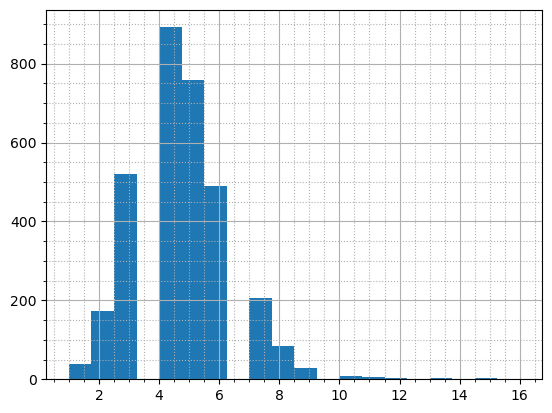

In [10]:
plt.hist((list(data_arc['key'].value_counts())), bins=20)
plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.show()

Столбец key содержит номер партии. Количество итераций обработки различается для каждой партии от 1 до 16. Мода - 4 итерации.

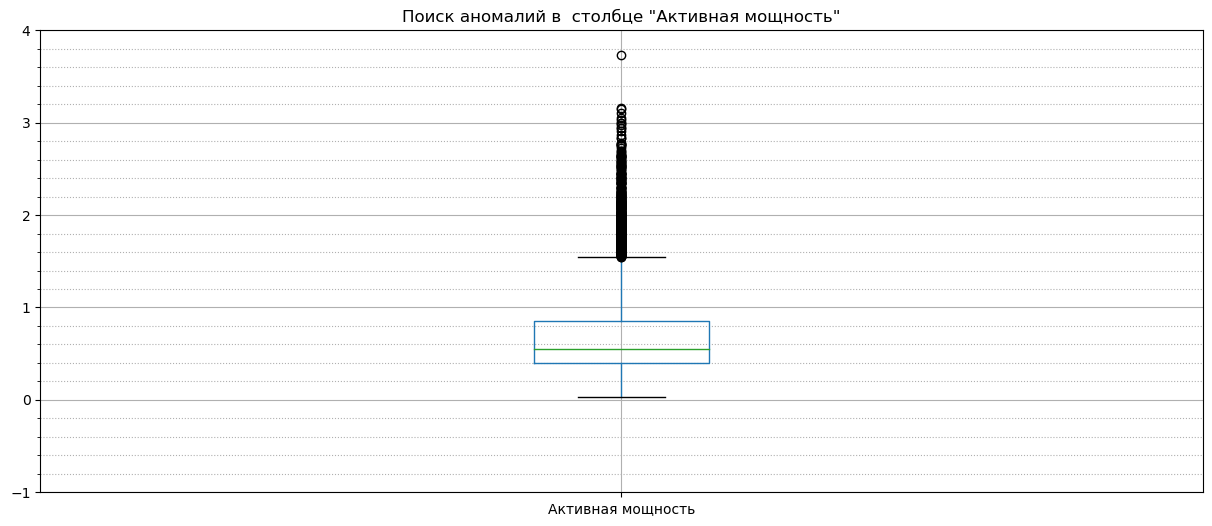

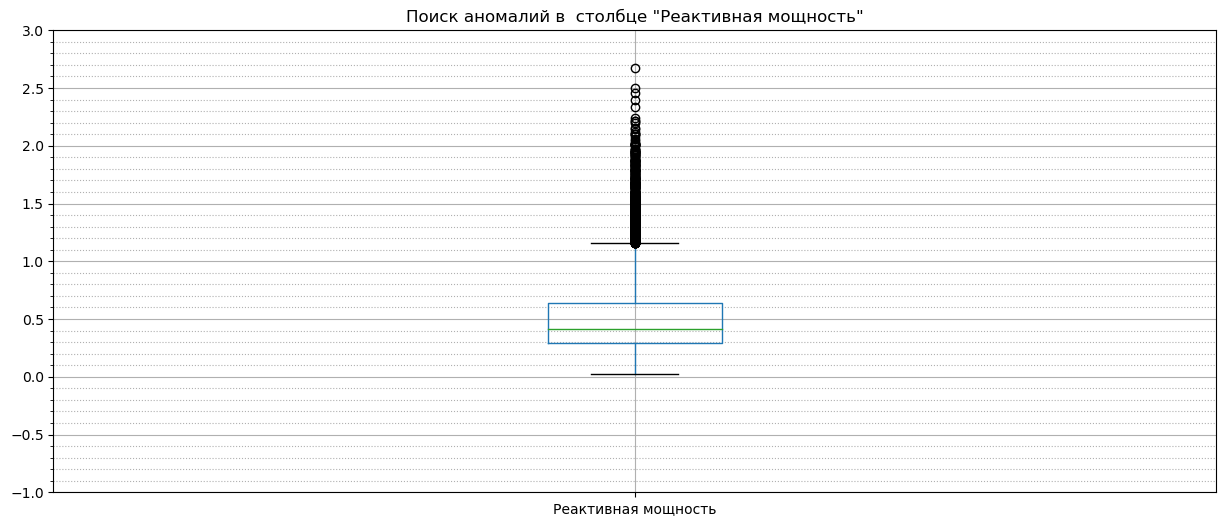

In [11]:
plt.figure(figsize=(15, 6))
data_arc.boxplot('Активная мощность')
plt.title('Поиск аномалий в  столбце "Активная мощность"', fontsize=12)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':')
plt.ylim(-1, 4)
plt.show()

plt.figure(figsize=(15, 6))
data_arc.boxplot('Реактивная мощность')
plt.title('Поиск аномалий в  столбце "Реактивная мощность"', fontsize=12)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':')
plt.ylim(-1, 3)
plt.show()

Выбивающееся значение уходит далеко за границы усов диаграммы размаха, что свидетельствует о его аномальности, что должно быть учтено при отборе данных для обучения модели. Так же для активной и реактивной мощностей присутствует большое количество выбросов под верхней границей усов. 
Обратимся к плотности распределения, чтобы посмотреть хвосты.

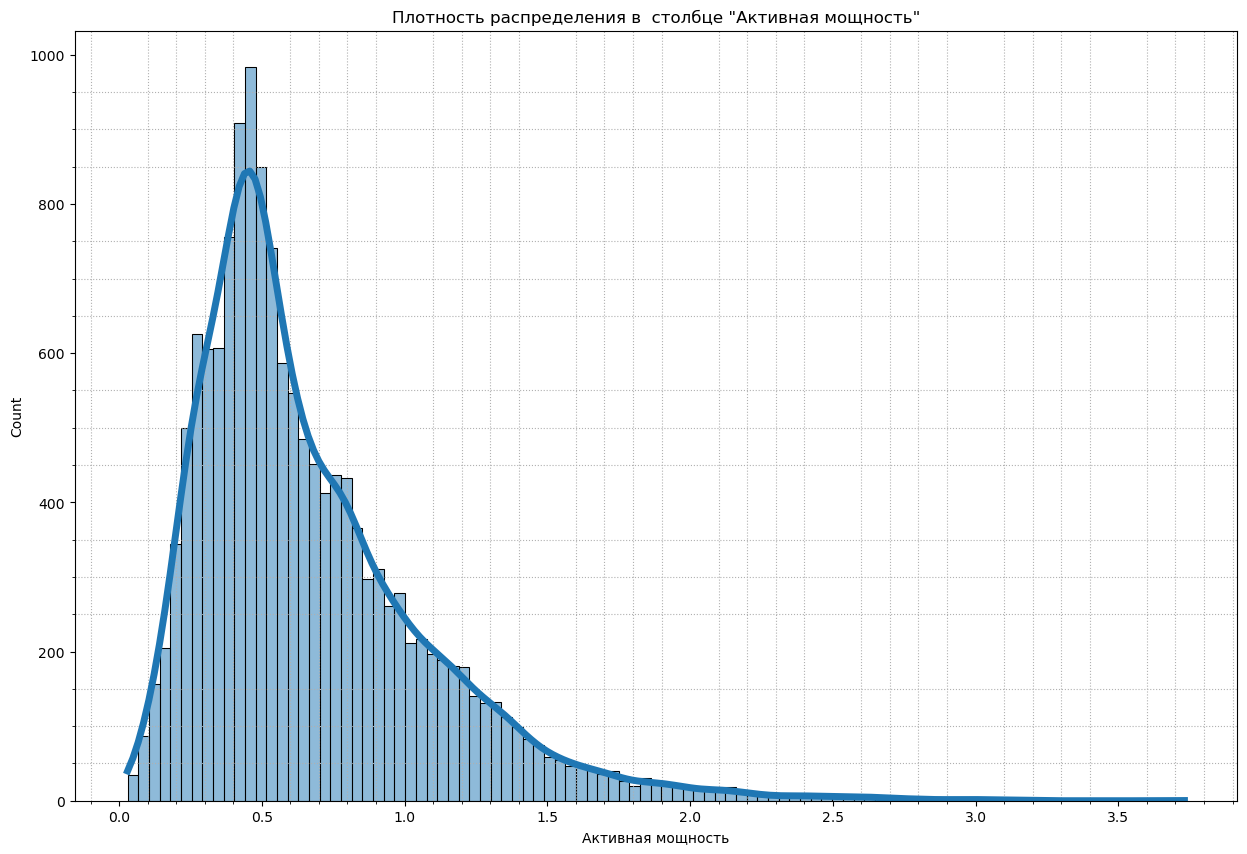

In [12]:
plt.figure(figsize=(15,10))
sns.histplot(data_arc['Активная мощность'], kde=True, line_kws={'linewidth':5})
plt.title('Плотность распределения в  столбце "Активная мощность"', fontsize=12)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':')
plt.show()

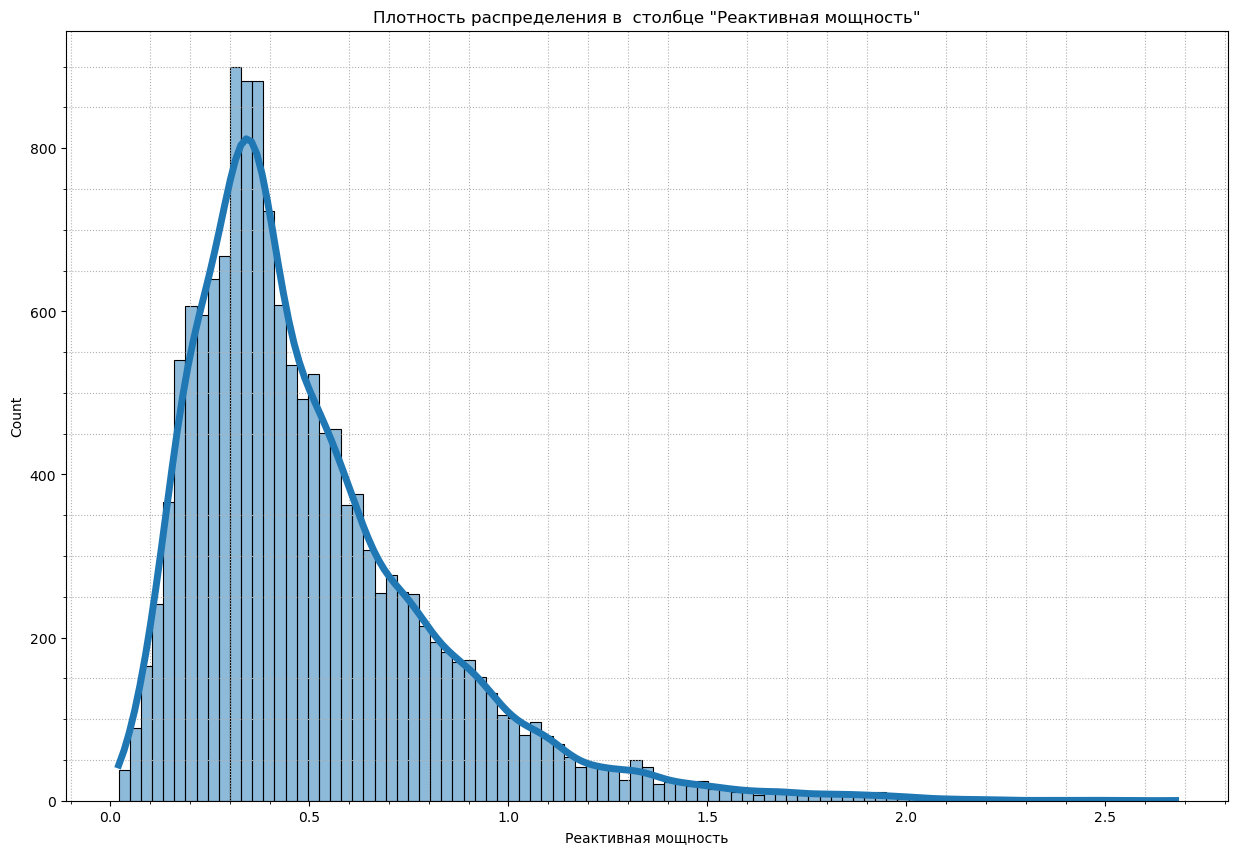

In [13]:
data_arc = data_arc[data_arc['Реактивная мощность']>=0] #уберем аномальное значение -715, чтобы снизить искажение на графике и повысить его читаемость

plt.figure(figsize=(15,10))
sns.histplot(data_arc['Реактивная мощность'], kde=True, line_kws={'linewidth':5})
plt.title('Плотность распределения в  столбце "Реактивная мощность"', fontsize=12)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':')
plt.show()

С опорой на визуализацию плотности распределения, можно сказать, что данные распределены нормально, имею хвосты справа. При отстутствии информации о технологических особенностях процесса, хвосты могут быть отсечены при фильтрации с опорой на диаграмму размаха.

Данные о подаче сыпучих метриалов (объём)

Таблица содержит большое количество пропусков, что связано с особенностями технологического процесса, такие пропуски чаще всего будут означать, что сыпучие материалы не подавались, соответственно пропуск может быть заполнен нулем.
Рассмотрим количество отсутствующих данных по партиям и оценим количество аномальных значений в таблице.

In [14]:
data_bulk['key'].value_counts().unique() #подтверждаем соответствие одной строки таблицы одной партии 

array([1], dtype=int64)

In [15]:
keys = list(data_bulk['key'])
no_value = []
for i in list(range(1, 3242)):
    if i not in keys:
        no_value.append(i)
len(no_value)

112

Таким образом, мы видим, что полностью отсутствуют данные о добавлении сыпучих материалов в 112 партий.
Теперь обратимся к диаграммам размаха.

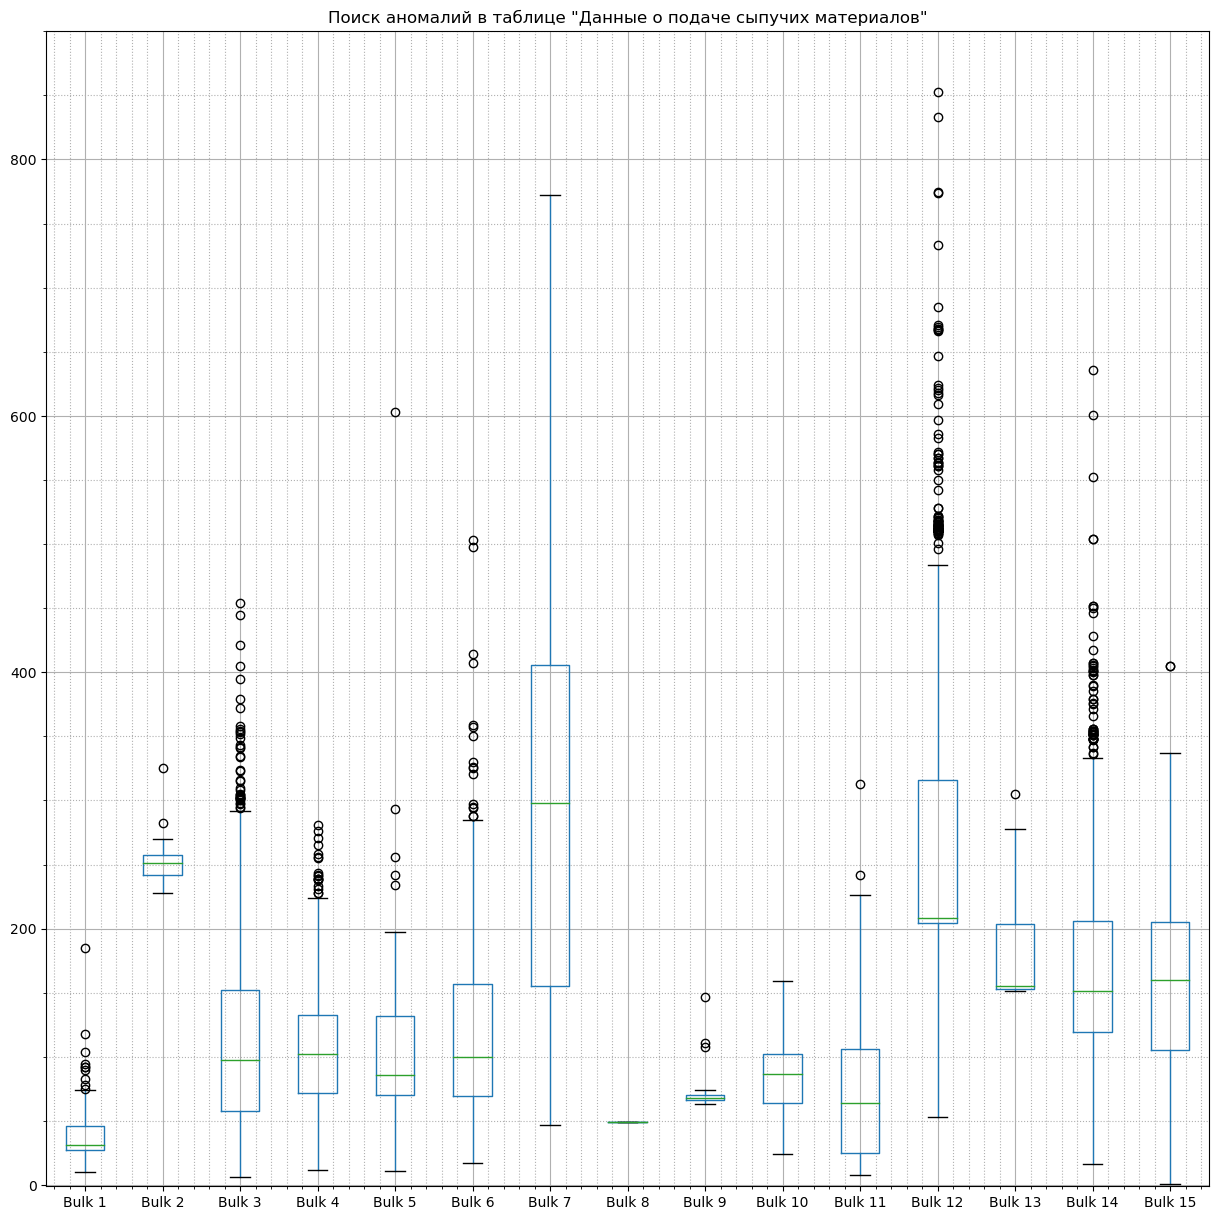

In [16]:
plt.figure(figsize=(15, 15))
data_bulk.boxplot([col for col in data_bulk.columns if col != 'key'])
plt.title('Поиск аномалий в таблице "Данные о подаче сыпучих материалов"', fontsize=12)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':')
plt.ylim(-1, 900)
plt.show()

Все столбцы имеют значения выходящие за границы усов, при этом bulk 8 добавлялось лишь единожны, так же bulk 12 имеет аномально высокое значение 1849 - оба эти значения могут быть исключены при отборе данных для избегания искажения модели

Рассмотрим данные о продувке сплава газом

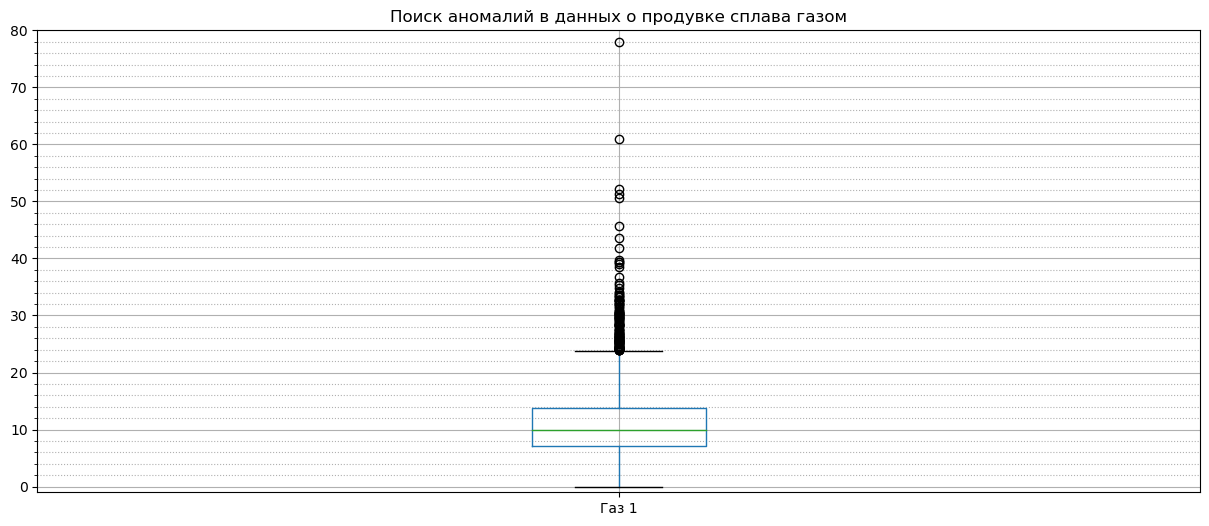

In [17]:
plt.figure(figsize=(15, 6))
data_gas.boxplot('Газ 1')
plt.title('Поиск аномалий в данных о продувке сплава газом', fontsize=12)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':')
plt.ylim(-1, 80)
plt.show()
plt.show()

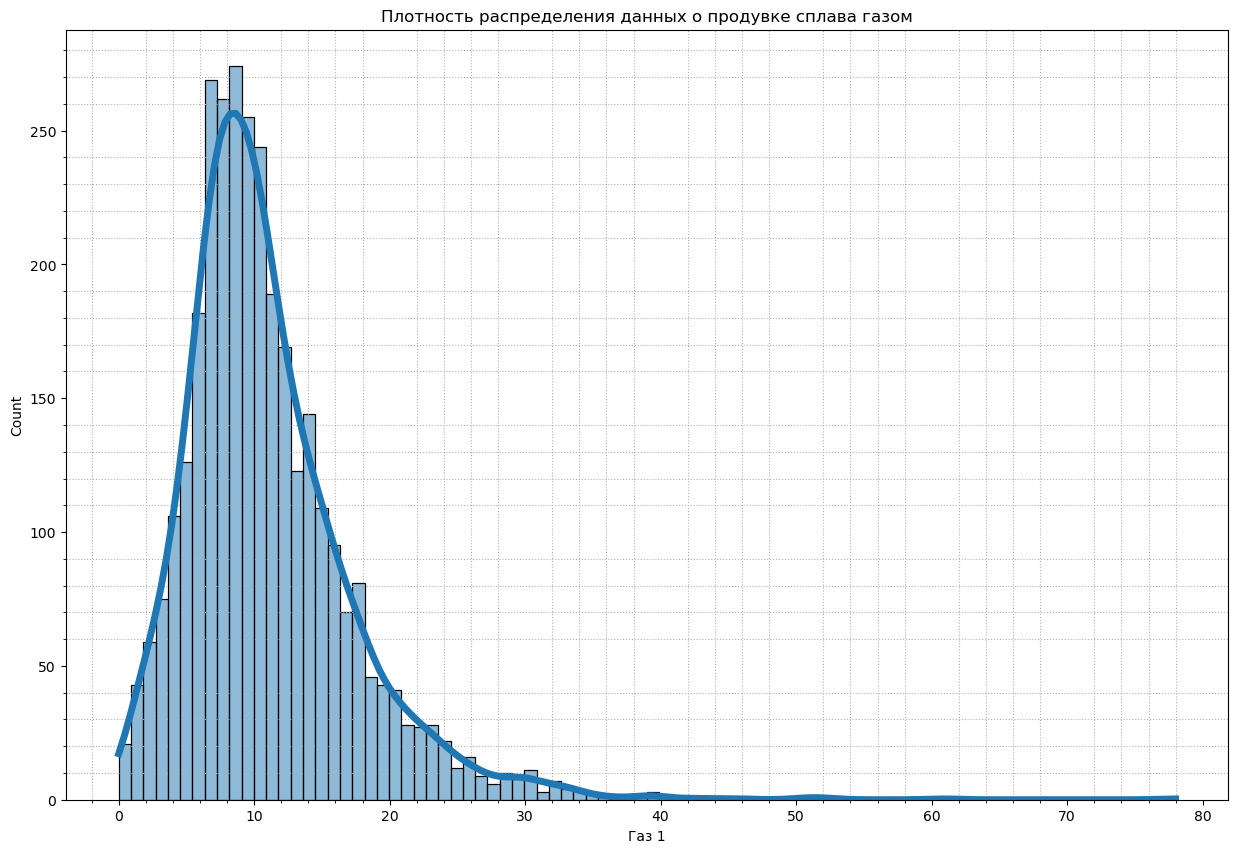

In [18]:
plt.figure(figsize=(15,10))
sns.histplot(data_gas['Газ 1'], kde=True, line_kws={'linewidth':5})
plt.title('Плотность распределения данных о продувке сплава газом', fontsize=12)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':')
plt.show()

Данные содержат большое количество выбросов за границы усов диаграммы размаха, исходя из плотности распределения, хвост справа может быть отсечен, для избежания искажения модели, при условии, что эти данные не являются необходимым условием технологического процесса.

Рассмотрим результаты измерения температуры

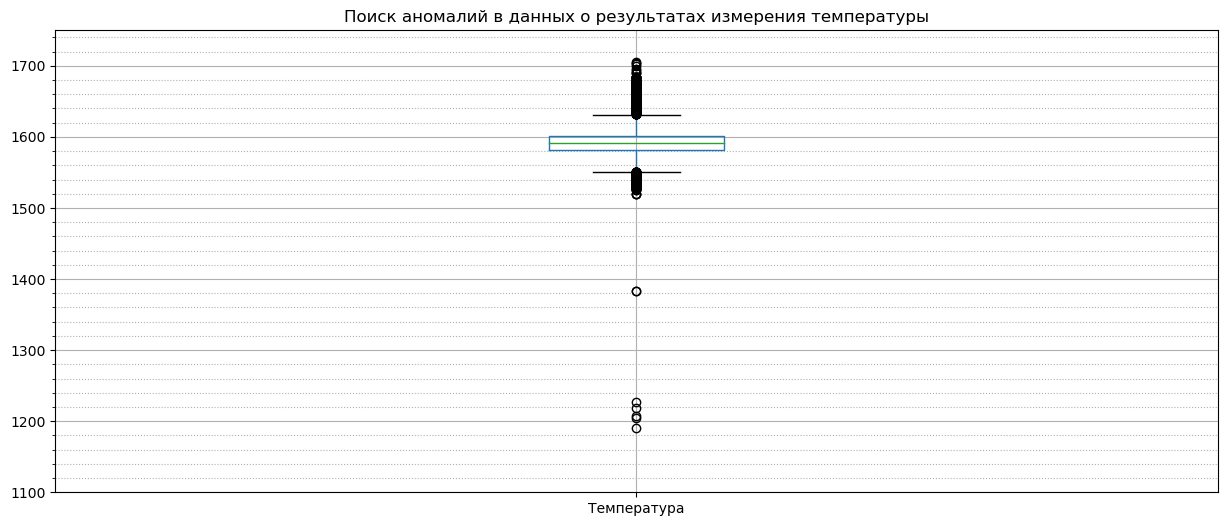

In [19]:
plt.figure(figsize=(15, 6))
data_temp.boxplot('Температура')
plt.title('Поиск аномалий в данных о результатах измерения температуры', fontsize=12)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':')
plt.ylim(1100, 1750)
plt.show()
plt.show()

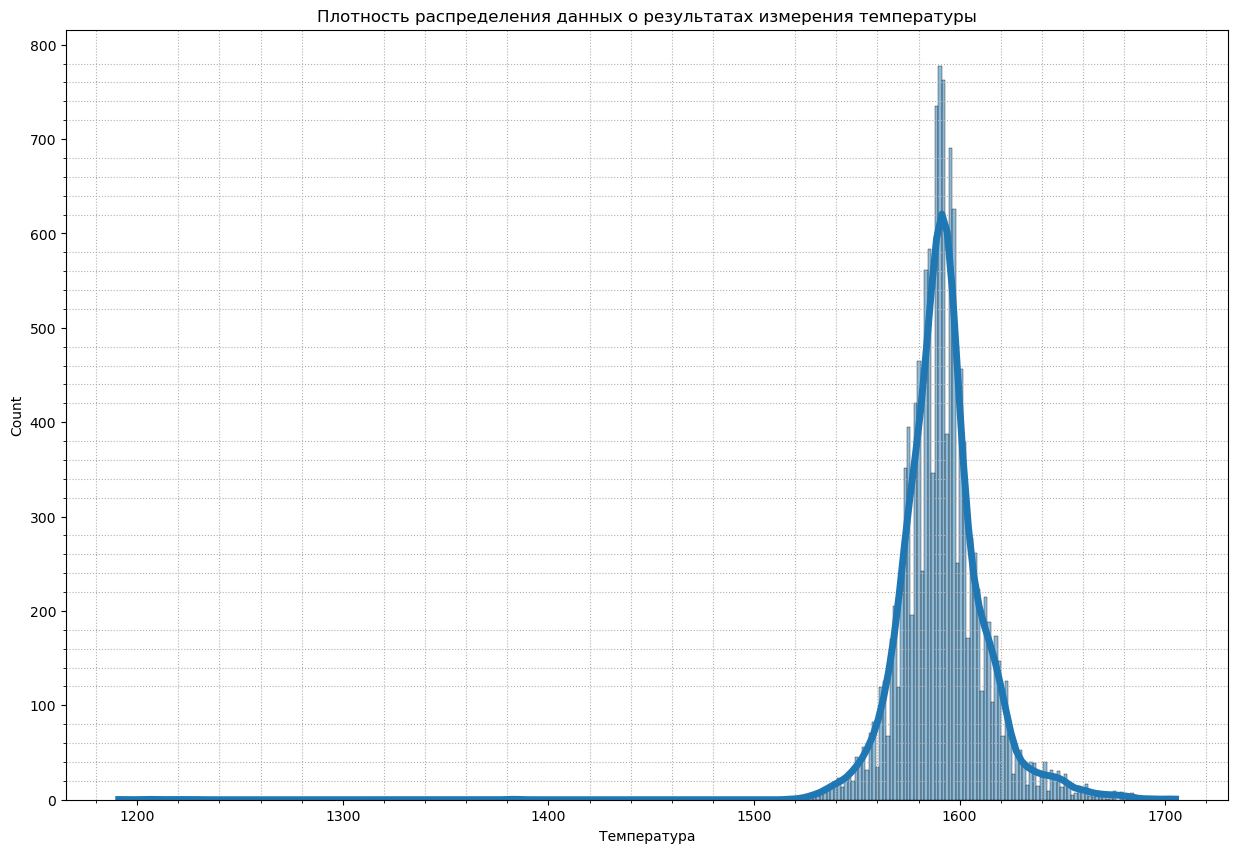

In [20]:
plt.figure(figsize=(15,10))
sns.histplot(data_temp['Температура'], kde=True, line_kws={'linewidth':5})
plt.title('Плотность распределения данных о результатах измерения температуры', fontsize=12)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':')
plt.show()

Известно, что температура плавления стали выше 1350 градусов, на основании этого знания хвост слева может быть отсечен. Так же встречаются аномально высокие значения, требующие уточнения со стороны технологов.

Рассмотрим данные о добавлении проволочных материалов

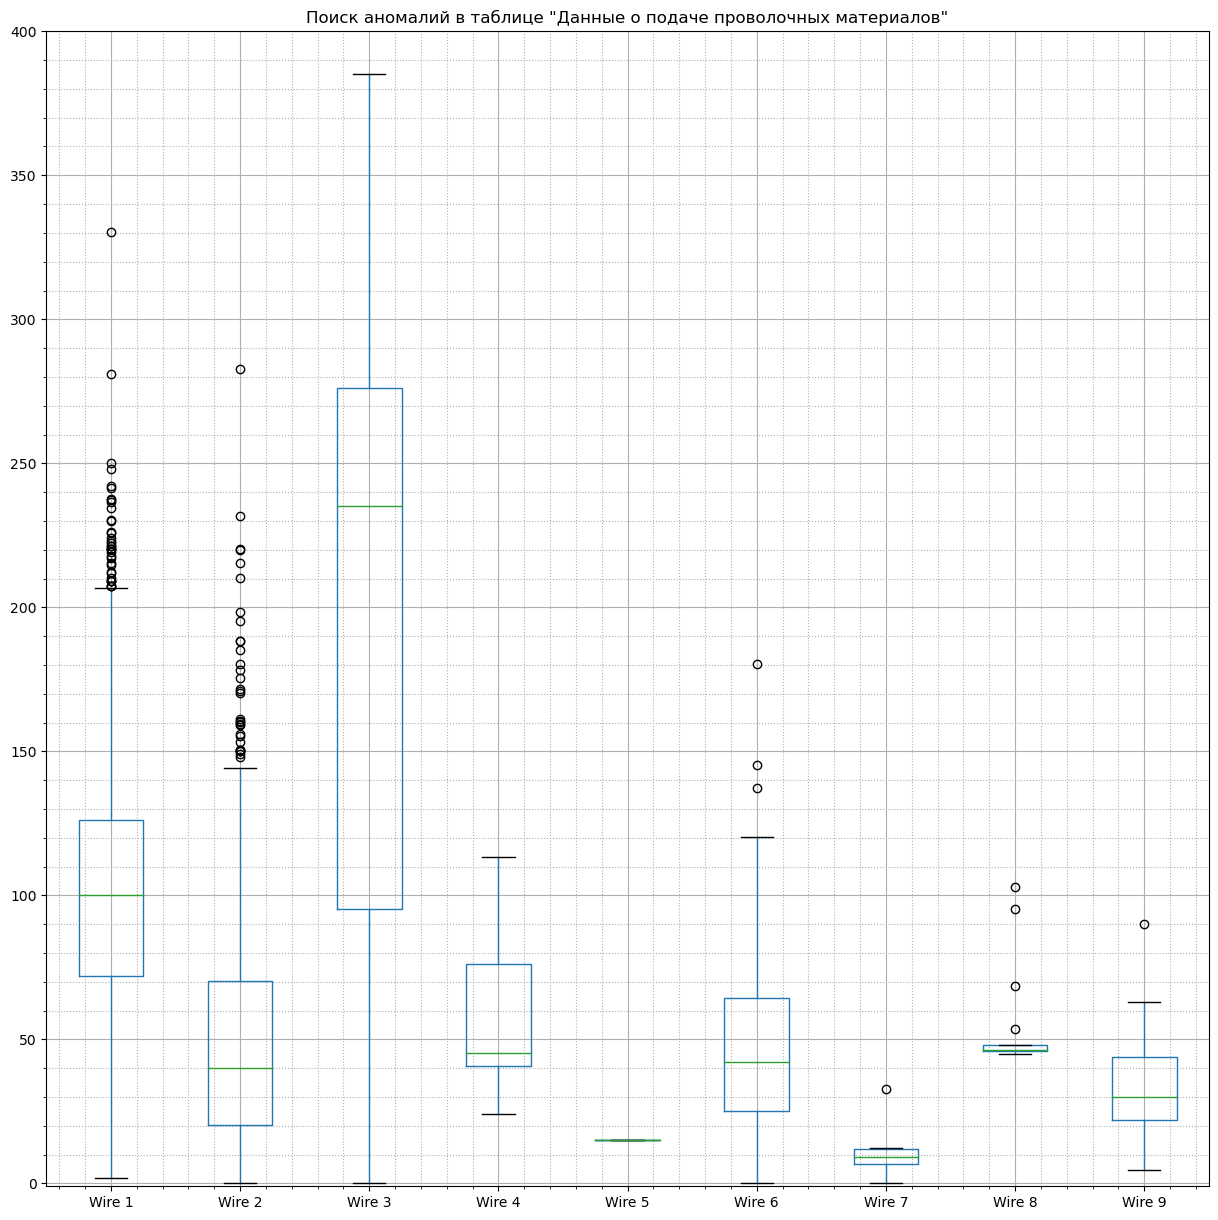

In [21]:
plt.figure(figsize=(15, 15))
data_wire.boxplot([col for col in data_wire.columns if col != 'key'])
plt.title('Поиск аномалий в таблице "Данные о подаче проволочных материалов"', fontsize=12)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':')
plt.ylim(-1, 400)
plt.show()

Некоторые столбцы имеют значения выходящие за границы усов, при этом wire 5 добавлялось лишь единожны, ввиду небольшого количества значений они могут быть отсечены при отборе данных, воизбежание искажения модели.

### 1.2 Вывод к исследовательскому анализу данных

После проведения исследовательского анализа можно сказать, что:

- Таблицы содержат данные, которые могут быть интерпретированы как выбросы
- Целевое значение содержит пропуски
- Имеются сведения о единичном добавлении сыпучих и проволочных материалов, которые могут быть отфильтрованы при отборе данных
- Пропуски в таблицах о внесении сыпучих и проволочных материалов могут быть заполненны нулем (материалы не вносились)
- Данные о продувке сплава газом содержат аномальные значения
- Данные о результатах измерения температуры содержат аномально-низкие значения (температура, ниже температуры плавления стали), такие значения следует отсечь для избегания искажений.

### 1.3 Проверка адекватности данных

Для уверенности в адекватности данных необходимо убедиться, что конечное измерение температуры производилось после прохождения всех технологических этапов, в частности добавления сыпучих и проволочных материалов.

Преобразуем таблицу с целевым признаком - последнее измерение температуры. Данные о первом измерении сохраним как дополнительный признак для обучения.

Приведем данные к нужному типу

In [22]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'], format='%Y-%m-%d %H:%M:%S')

In [23]:
data_temp

key        Время замера  Температура
0         1 2019-05-03 11:16:18       1571.0
1         1 2019-05-03 11:25:53       1604.0
2         1 2019-05-03 11:29:11       1618.0
3         1 2019-05-03 11:30:01       1601.0
4         1 2019-05-03 11:30:39       1613.0
...     ...                 ...          ...
15902  3241 2019-09-01 04:03:30       1586.0
15903  3241 2019-09-01 04:16:12          NaN
15904  3241 2019-09-01 04:22:39          NaN
15905  3241 2019-09-01 04:33:42          NaN
15906  3241 2019-09-01 04:38:08          NaN

[15907 rows x 3 columns]

Составим таблицу с последним измерением температуры

In [24]:
last_temp = data_temp.groupby('key').agg('max')['Время замера']
last_temp = pd.DataFrame(last_temp)
last_temp = last_temp.merge(data_temp, on='Время замера', how='left')
last_temp.set_axis(['time_last','key','temp_last'], axis = 'columns', inplace = True)

In [25]:
last_temp.head(5)

time_last  key  temp_last
0 2019-05-03 11:30:39    1     1613.0
1 2019-05-03 11:59:12    2     1602.0
2 2019-05-03 12:34:57    3     1599.0
3 2019-05-03 12:59:25    4     1625.0
4 2019-05-03 13:36:01    5     1602.0

Аналогично вынесем результаты первого замера в отдельную таблицу

In [26]:
first_temp = data_temp.groupby('key').agg('min')['Время замера']
first_temp = pd.DataFrame(first_temp)
first_temp = first_temp.merge(data_temp, on='Время замера', how='left')
first_temp.set_axis(['time_first','key','temp_first'], axis = 'columns', inplace = True)

In [27]:
first_temp.head(5)

time_first  key  temp_first
0 2019-05-03 11:16:18    1      1571.0
1 2019-05-03 11:37:27    2      1581.0
2 2019-05-03 12:13:17    3      1596.0
3 2019-05-03 12:52:57    4      1601.0
4 2019-05-03 13:23:19    5      1576.0

Объединим таблицы

In [28]:
df = first_temp.merge(last_temp, on='key', how='left')\
                  .reindex(columns=['key', 'time_first', 'temp_first', 'time_last', 'temp_last'])

In [29]:
df

key          time_first  temp_first           time_last  temp_last
0        1 2019-05-03 11:16:18      1571.0 2019-05-03 11:30:39     1613.0
1        2 2019-05-03 11:37:27      1581.0 2019-05-03 11:59:12     1602.0
2        3 2019-05-03 12:13:17      1596.0 2019-05-03 12:34:57     1599.0
3        4 2019-05-03 12:52:57      1601.0 2019-05-03 12:59:25     1625.0
4        5 2019-05-03 13:23:19      1576.0 2019-05-03 13:36:01     1602.0
...    ...                 ...         ...                 ...        ...
3211  3237 2019-08-31 22:44:04      1569.0 2019-08-31 23:05:43        NaN
3212  3238 2019-08-31 23:30:31      1584.0 2019-08-31 23:43:00        NaN
3213  3239 2019-09-01 01:31:47      1598.0 2019-09-01 02:24:15        NaN
3214  3240 2019-09-01 02:39:01      1617.0 2019-09-01 03:35:16        NaN
3215  3241 2019-09-01 04:03:30      1586.0 2019-09-01 04:38:08        NaN

[3216 rows x 5 columns]

In [30]:
keys_na = list(df[df['temp_last'].isna()]['key'])
keys_not_na = list(df[~df['temp_last'].isna()]['key'])

In [31]:
df.isna().sum()

key             0
time_first      0
temp_first      0
time_last       0
temp_last     739
dtype: int64

Целевой признак содержит пропуски, корректное заполнение в такой ситуации невозможно, значение-заглушка будет зашумлять данные, поэтому принимается решение удалить такие строки, если не будет других пожеланий от заказчика.

In [32]:
df = df.dropna()
df

key          time_first  temp_first           time_last  temp_last
0        1 2019-05-03 11:16:18      1571.0 2019-05-03 11:30:39     1613.0
1        2 2019-05-03 11:37:27      1581.0 2019-05-03 11:59:12     1602.0
2        3 2019-05-03 12:13:17      1596.0 2019-05-03 12:34:57     1599.0
3        4 2019-05-03 12:52:57      1601.0 2019-05-03 12:59:25     1625.0
4        5 2019-05-03 13:23:19      1576.0 2019-05-03 13:36:01     1602.0
...    ...                 ...         ...                 ...        ...
2472  2495 2019-08-06 00:35:45      1570.0 2019-08-06 00:54:42     1591.0
2473  2496 2019-08-06 01:02:54      1554.0 2019-08-06 01:29:52     1591.0
2474  2497 2019-08-06 01:41:53      1571.0 2019-08-06 01:53:50     1589.0
2475  2498 2019-08-06 02:03:49      1591.0 2019-08-06 02:25:31     1594.0
2476  2499 2019-08-06 02:40:25      1569.0 2019-08-06 03:00:28     1603.0

[2477 rows x 5 columns]

Посмотрим, содержит ли таблица строки где первое измерение равно последнему

In [33]:
(df[df['temp_first'] == df['temp_last']]).count()

key           44
time_first    44
temp_first    44
time_last     44
temp_last     44
dtype: int64

Такие строки есть, в масштабе набора данных их немного, лучше избавиться от них во избежание утечки данных при разделении на выборки.

In [34]:
df = df[df['temp_first'] != df['temp_last']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2433 entries, 0 to 2476
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   key         2433 non-null   int64         
 1   time_first  2433 non-null   datetime64[ns]
 2   temp_first  2433 non-null   float64       
 3   time_last   2433 non-null   datetime64[ns]
 4   temp_last   2433 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 114.0 KB


Приведем данные о времени нагрева электродов дугой к типа datetime

In [35]:
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')

С помощью циклов приведем к формату datetime даннные в времени подачи сыпучих и проволочных материалов

In [36]:
for col in data_bulk_time:
    if col != 'key':
        data_bulk_time[col] = pd.to_datetime(data_bulk_time[col], format='%Y-%m-%d %H:%M:%S')
        
for col in data_wire_time:
    if col != 'key':
        data_wire_time[col] = pd.to_datetime(data_wire_time[col], format='%Y-%m-%d %H:%M:%S')

Обединим данные в таблицу с последним временем нагрева

In [37]:
data_arc_lasttime = pd.DataFrame(data_arc.groupby('key').agg('max')['Конец нагрева дугой'])
data_arc_lasttime.reset_index(inplace=True)

In [38]:
data_arc_lasttime 


key Конец нагрева дугой
0        1 2019-05-03 11:28:37
1        2 2019-05-03 11:53:18
2        3 2019-05-03 12:32:19
3        4 2019-05-03 12:57:50
4        5 2019-05-03 13:33:55
...    ...                 ...
3209  3237 2019-08-31 23:03:48
3210  3238 2019-08-31 23:41:28
3211  3239 2019-09-01 02:15:43
3212  3240 2019-09-01 03:34:08
3213  3241 2019-09-01 04:36:08

[3214 rows x 2 columns]

Запишем функцию для построчной проверки совпадения последнего времени нагрева с максимальным,
а так же функцию для объединения таблиц, с таблицей содержащей целевой признак и построчным выводом несоответвий

In [39]:
def check_time(row):
    return row['time_last'] == row['max_time']

In [40]:
def error_list(datas_list):
    data = df[['key', 'time_last']].merge(datas_list[0], on='key', how='left')
    for dataset in datas_list[1:]:
        data = data.merge(dataset, on='key', how='left')
    data['max_time'] = data.drop('key', axis=1).max(axis=1)
    data['check_error'] = data.apply(check_time, axis=1)
    keys = list(data[data['check_error'] == 0]['key'])
    return keys

Подсчитаем количество строк непрошедших проверку

In [41]:
data_with_time = [data_arc_lasttime, data_bulk_time, data_wire_time]
keys_errors = error_list(data_with_time)

len(keys_errors)

134

Таким образом проверку не прошли суммарно 178 строк, которые рекомендовано удалить, во избежание искажений в работе модели.

Заполним пропуски в данных о подаче сыпучих и проволочных материалов 0, т.к. отстутсвие данных значит, что материалы не подавались.

In [43]:
data_wire = data_wire.fillna(0)
display(data_wire.head(5))

key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
1    2  96.052315  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
2    3  91.160157  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
3    4  89.063515  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
4    5  89.238236  9.11456     0.0     0.0     0.0     0.0     0.0     0.0   

   Wire 9  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0

In [44]:
data_bulk = data_bulk.fillna(0)
display(data_bulk.head(5))

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     0.0     0.0     0.0    43.0     0.0     0.0     0.0     0.0   
1    2     0.0     0.0     0.0    73.0     0.0     0.0     0.0     0.0   
2    3     0.0     0.0     0.0    34.0     0.0     0.0     0.0     0.0   
3    4     0.0     0.0     0.0    81.0     0.0     0.0     0.0     0.0   
4    5     0.0     0.0     0.0    78.0     0.0     0.0     0.0     0.0   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     0.0      0.0      0.0    206.0      0.0    150.0    154.0  
1     0.0      0.0      0.0    206.0      0.0    149.0    154.0  
2     0.0      0.0      0.0    205.0      0.0    152.0    153.0  
3     0.0      0.0      0.0    207.0      0.0    153.0    154.0  
4     0.0      0.0      0.0    203.0      0.0    151.0    152.0

In [45]:
df = pd.merge(df, data_gas, how="inner", on=["key"])
df = pd.merge(df, data_wire, how="inner", on=["key"])
df = pd.merge(df, data_bulk, how="inner", on=["key"])
df = pd.merge(df, data_arc[['key', 'Активная мощность','Реактивная мощность']].groupby('key').sum(), how="inner", on=["key"]) # sum of powers
df = df.set_index('key')
df.head(5)

time_first  temp_first           time_last  temp_last      Газ 1  \
key                                                                             
1   2019-05-03 11:16:18      1571.0 2019-05-03 11:30:39     1613.0  29.749986   
2   2019-05-03 11:37:27      1581.0 2019-05-03 11:59:12     1602.0  12.555561   
3   2019-05-03 12:13:17      1596.0 2019-05-03 12:34:57     1599.0  28.554793   
4   2019-05-03 12:52:57      1601.0 2019-05-03 12:59:25     1625.0  18.841219   
5   2019-05-03 13:23:19      1576.0 2019-05-03 13:36:01     1602.0   5.413692   

        Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  ...  Bulk 8  Bulk 9  Bulk 10  \
key                                              ...                            
1    60.059998  0.00000     0.0     0.0     0.0  ...     0.0     0.0      0.0   
2    96.052315  0.00000     0.0     0.0     0.0  ...     0.0     0.0      0.0   
3    91.160157  0.00000     0.0     0.0     0.0  ...     0.0     0.0      0.0   
4    89.063515  0.00000     0.0     0.0     0.0  ...     0.0     0.0      0.0   
5    89.238236  9.11456     0.0     0.0     0.0  ...     0.0     0.0      0.0   

     Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  Активная мощность  \
key                                                                   
1        0.0    206.0      0.0    150.0    154.0           4.878147   
2        0.0    206.0      0.0    149.0    154.0           3.052598   
3        0.0    205.0      0.0    152.0    153.0           2.525882   
4        0.0    207.0      0.0    153.0    154.0           3.209250   
5        0.0    203.0      0.0    151.0    152.0           3.347173   

     Реактивная мощность  
key                       
1               3.183241  
2               1.998112  
3               1.599076  
4               2.060298  
5               2.252643  

[5 rows x 31 columns]

Обратим внимание, на столбец Wire  5

In [46]:
df['Wire 5']

key
1       0.0
2       0.0
3       0.0
4       0.0
5       0.0
       ... 
2495    0.0
2496    0.0
2497    0.0
2498    0.0
2499    0.0
Name: Wire 5, Length: 2293, dtype: float64

In [47]:
df['Wire 5'].sum()

0.0

Столбец не содержит данных, удалим его.

In [48]:
df = df.drop(['Wire 5'], axis=1)

Рассмотрим график замера температуры в зависимости от времени

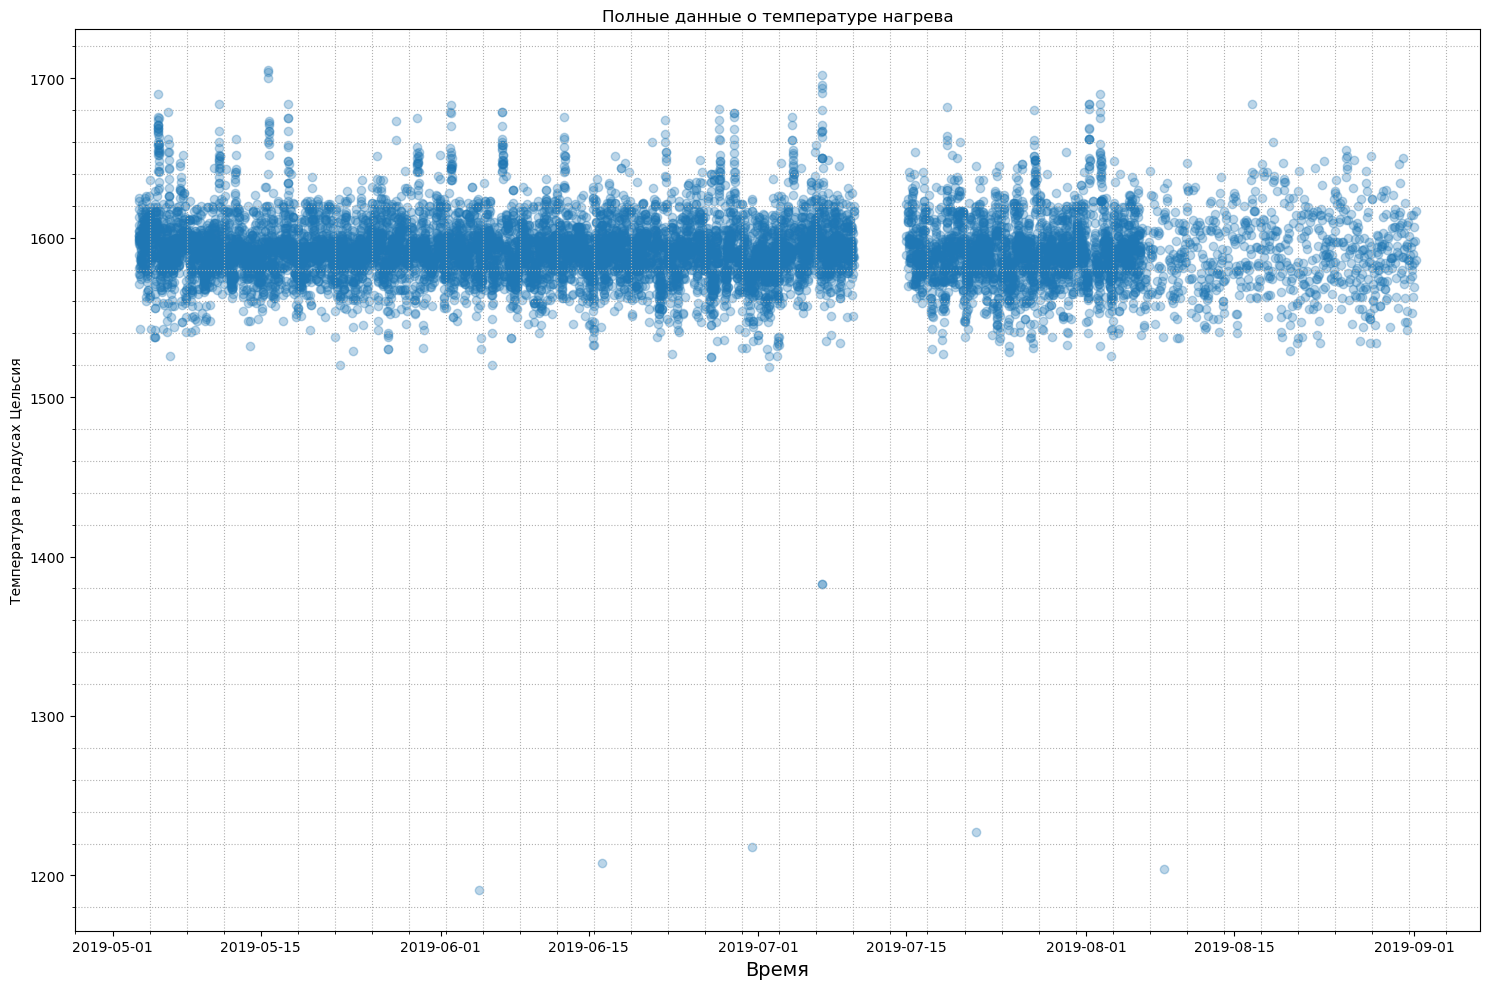

In [49]:
plt.figure(figsize=(15,10))
plt.title('Полные данные о температуре нагрева', fontsize=12)
plt.xlabel('Время', fontsize=14)
plt.ylabel("Температура в градусах Цельсия", fontsize=10)
plt.scatter(x=data_temp['Время замера'], y=data_temp['Температура'], alpha=0.3)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':')
plt.tight_layout()
plt.show()

In [50]:
print(f"Интервал наблюдений: {data_temp['Время замера'].min()} - {data_temp['Время замера'].max()}")

Интервал наблюдений: 2019-05-03 11:16:18 - 2019-09-01 04:38:08


Рассмотрим график распредения измерений температур

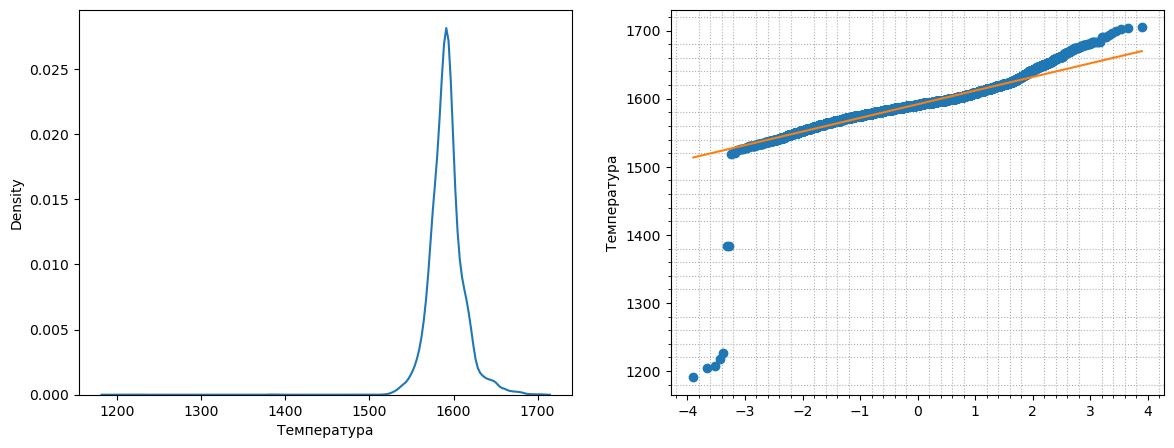

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.kdeplot(data_temp['Температура'], ax=ax[0])
plt.minorticks_on()
plt.grid(which='minor', linestyle=':')
fig = probscale.probplot(
    data_temp['Температура'].dropna(),
    ax=ax[1],
    plottype='qq',
    bestfit=True)
ax[1].set_ylabel('Температура')
plt.minorticks_on()
plt.grid(which='minor', linestyle=':')
plt.show()

Изменений, связанных со временем замера не выявлено, так же визуализация доволнительно подтверждает налиние аномалий в данных.

Построим график замеров начальной температуры и конечной температуры по партиям

Воспользуемся функцией для создания диаграмм распределения и размаха

In [52]:
def plot_scatter_box(df, columns, size=(10,5), alpha=0.5, title=None, xlabel=None, ylabel=None):
    fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]})
    fig.set_size_inches(size)
    ax[0].set_title(title, fontsize=12)
    ax[0].set_xlabel(xlabel, fontsize=10)
    ax[0].set_ylabel(ylabel, fontsize=10)
    for clm in columns:
        ax[0].scatter(x=df.index, y=df[clm], label=clm, alpha=alpha) 
    if len(columns) > 1:
        ax[0].legend()
    ax[0].grid(True)
    ax[1].boxplot(df[columns], labels=[*columns])
    plt.tight_layout()
    plt.minorticks_on()
    plt.grid(which='minor', linestyle=':')
    plt.show()

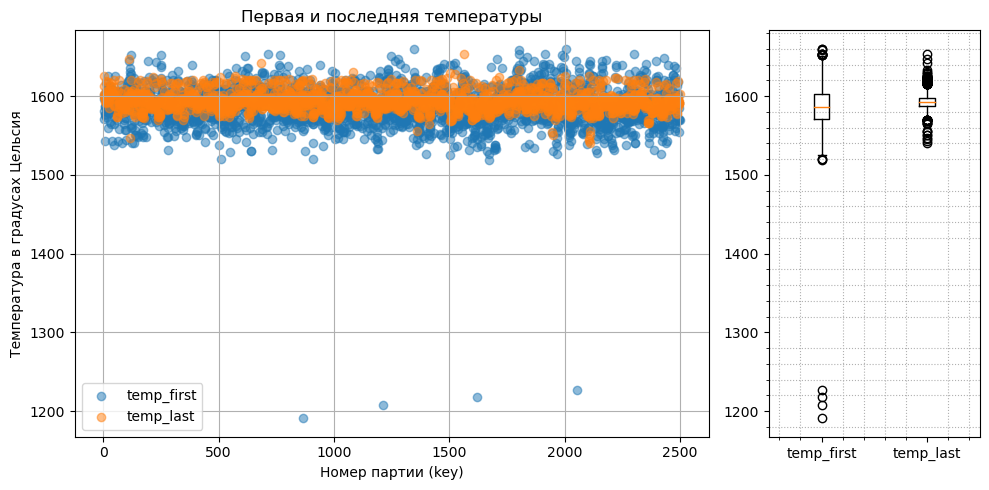

In [53]:
plot_scatter_box(df, ['temp_first','temp_last'], title='Первая и последняя температуры', xlabel='Номер партии (key)', ylabel='Температура в градусах Цельсия')

In [54]:
df[['temp_first','temp_last']].describe()

temp_first    temp_last
count  2293.000000  2293.000000
mean   1586.618404  1593.369385
std      28.457503    11.179055
min    1191.000000  1541.000000
25%    1571.000000  1587.000000
50%    1586.000000  1593.000000
75%    1603.000000  1598.000000
max    1660.000000  1653.000000

Можно отметить разброс значений конечной температуры, который ниже, чем разброс начальной температуры. Очевидных различий между партиями не наблюдается
Снова подтверждается наличие аномально-низких температрур. Есть необходимость уточнить информацию у заказчика по этому поводу.
Рассмотрим, как изменятся графики при отсечении аномально-низких значений.

In [55]:
treshold = 1350

In [56]:
df.loc[df['temp_first'] < treshold, 'temp_first'] = data_temp[data_temp['key'].isin(
    df[df['temp_first'] < treshold].index.to_list())].groupby('key').nth(1)['Температура']

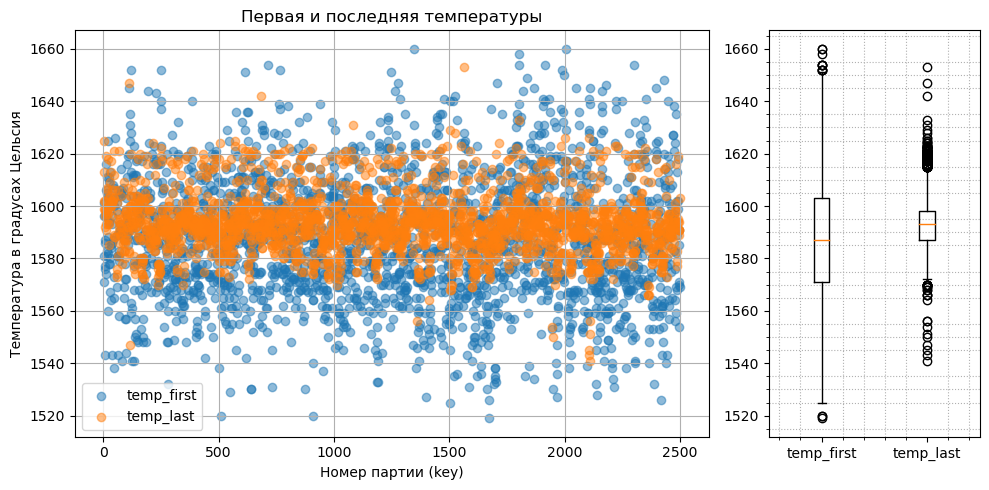

In [57]:
plot_scatter_box(df, ['temp_first','temp_last'], title='Первая и последняя температуры', xlabel='Номер партии (key)', ylabel='Температура в градусах Цельсия')

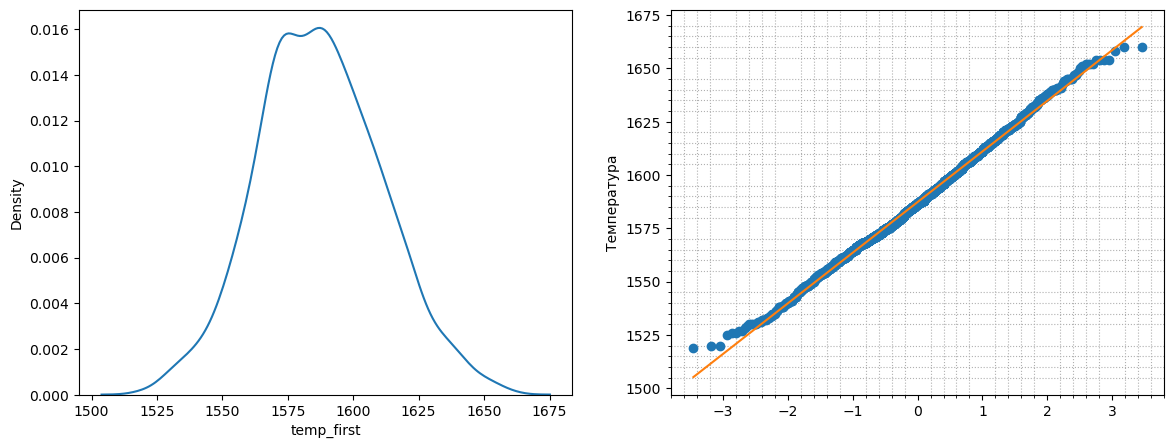

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.kdeplot(df['temp_first'], ax=ax[0])
fig = probscale.probplot(
    df['temp_first'],
    ax=ax[1],
    plottype='qq',
    bestfit=True
)
ax[1].set_ylabel('Температура')
plt.minorticks_on()
plt.grid(which='minor', linestyle=':')
plt.show()

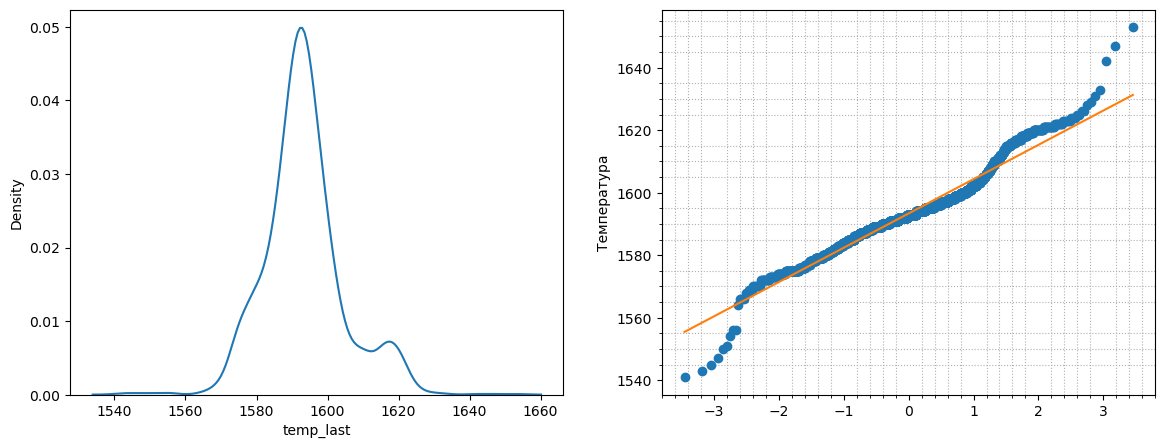

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.kdeplot(df['temp_last'], ax=ax[0])
fig = probscale.probplot(
    df['temp_last'],
    ax=ax[1],
    plottype='qq',
    bestfit=True
)
ax[1].set_ylabel('Температура')
plt.minorticks_on()
plt.grid(which='minor', linestyle=':')
plt.show()

Расчитаем суммарное время и количество нагревов

In [60]:
data_arc['heat_time'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).dt.total_seconds()
df_del = data_arc[['key','heat_time']].groupby('key', as_index=False).agg(['sum','count'])
df_del.columns = ['heat_time', 'heat_count']
df_temp = pd.merge(df, df_del, how='left', on='key')
del df_del

In [61]:
df_temp

time_first  temp_first           time_last  temp_last  \
key                                                                   
1    2019-05-03 11:16:18      1571.0 2019-05-03 11:30:39     1613.0   
2    2019-05-03 11:37:27      1581.0 2019-05-03 11:59:12     1602.0   
3    2019-05-03 12:13:17      1596.0 2019-05-03 12:34:57     1599.0   
4    2019-05-03 12:52:57      1601.0 2019-05-03 12:59:25     1625.0   
5    2019-05-03 13:23:19      1576.0 2019-05-03 13:36:01     1602.0   
...                  ...         ...                 ...        ...   
2495 2019-08-06 00:35:45      1570.0 2019-08-06 00:54:42     1591.0   
2496 2019-08-06 01:02:54      1554.0 2019-08-06 01:29:52     1591.0   
2497 2019-08-06 01:41:53      1571.0 2019-08-06 01:53:50     1589.0   
2498 2019-08-06 02:03:49      1591.0 2019-08-06 02:25:31     1594.0   
2499 2019-08-06 02:40:25      1569.0 2019-08-06 03:00:28     1603.0   

          Газ 1      Wire 1    Wire 2  Wire 3  Wire 4  Wire 6  ...  Bulk 10  \
key                                                            ...            
1     29.749986   60.059998   0.00000     0.0     0.0     0.0  ...      0.0   
2     12.555561   96.052315   0.00000     0.0     0.0     0.0  ...      0.0   
3     28.554793   91.160157   0.00000     0.0     0.0     0.0  ...      0.0   
4     18.841219   89.063515   0.00000     0.0     0.0     0.0  ...      0.0   
5      5.413692   89.238236   9.11456     0.0     0.0     0.0  ...      0.0   
...         ...         ...       ...     ...     ...     ...  ...      ...   
2495   7.125735   89.150879   0.00000     0.0     0.0     0.0  ...     90.0   
2496   9.412616  114.179527   0.00000     0.0     0.0     0.0  ...    122.0   
2497   6.271699   94.086723   9.04800     0.0     0.0     0.0  ...      0.0   
2498  14.953657  118.110717   0.00000     0.0     0.0     0.0  ...    101.0   
2499  11.336151  110.160958  50.00528     0.0     0.0     0.0  ...      0.0   

      Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  Активная мощность  \
key                                                                    
1         0.0    206.0      0.0    150.0    154.0           4.878147   
2         0.0    206.0      0.0    149.0    154.0           3.052598   
3         0.0    205.0      0.0    152.0    153.0           2.525882   
4         0.0    207.0      0.0    153.0    154.0           3.209250   
5         0.0    203.0      0.0    151.0    152.0           3.347173   
...       ...      ...      ...      ...      ...                ...   
2495      0.0    256.0      0.0    129.0    223.0           3.210690   
2496      0.0    256.0      0.0    129.0    226.0           4.203064   
2497      0.0    230.0      0.0    124.0    226.0           2.212379   
2498      0.0    206.0      0.0    129.0    207.0           3.408725   
2499      0.0    233.0      0.0    126.0    227.0           4.098431   

      Реактивная мощность  heat_time  heat_count  
key                                               
1                3.183241     1098.0           5  
2                1.998112      811.0           4  
3                1.599076      655.0           5  
4                2.060298      741.0           4  
5                2.252643      869.0           4  
...                   ...        ...         ...  
2495             2.360777      723.0           4  
2496             2.810185      940.0           6  
2497             1.851269      569.0           3  
2498             2.355428      750.0           5  
2499             2.777865      883.0           4  

[2293 rows x 32 columns]

Построим график времени нагрева нагрева дугой

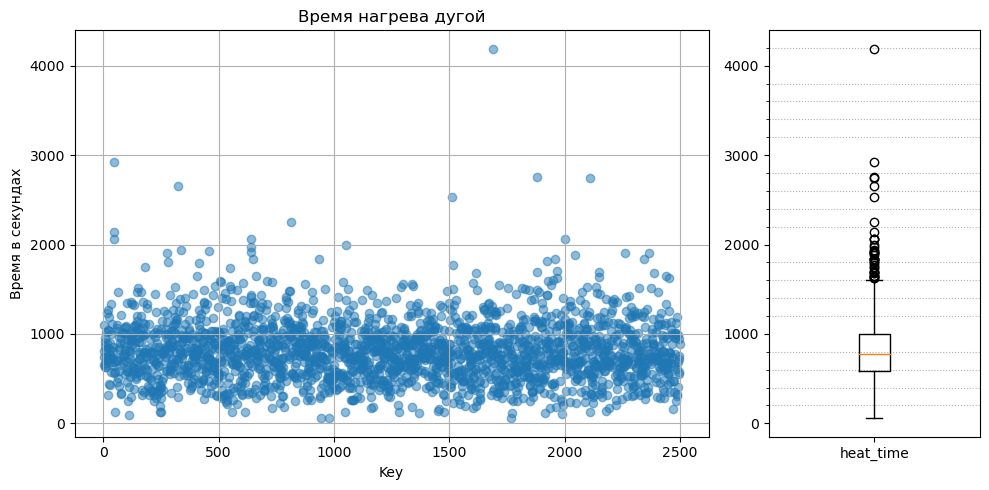

In [62]:
plot_scatter_box(df_temp, ['heat_time'], title='Время нагрева дугой', xlabel='Key', ylabel='Время в секундах')

Построим график активной и реактивной мощности

In [63]:
df[['Активная мощность','Реактивная мощность']].describe()

Активная мощность  Реактивная мощность
count        2293.000000          2293.000000
mean            3.159618             2.355581
std             1.427323             1.083146
min             0.186226             0.158247
25%             2.190623             1.628309
50%             3.034115             2.240437
75%             3.928126             2.924655
max            17.496497            12.587990

Вычислим отношение активной мощности к реактивной и заменим выброс в реактивной мощности значением расчета

In [64]:
df['ratio'] = df['Реактивная мощность'] / df['Активная мощность']

In [65]:
df['ratio'].describe()

count    2293.000000
mean        0.749891
std         0.088533
min         0.562708
25%         0.698712
50%         0.734571
75%         0.781598
max         1.641433
Name: ratio, dtype: float64

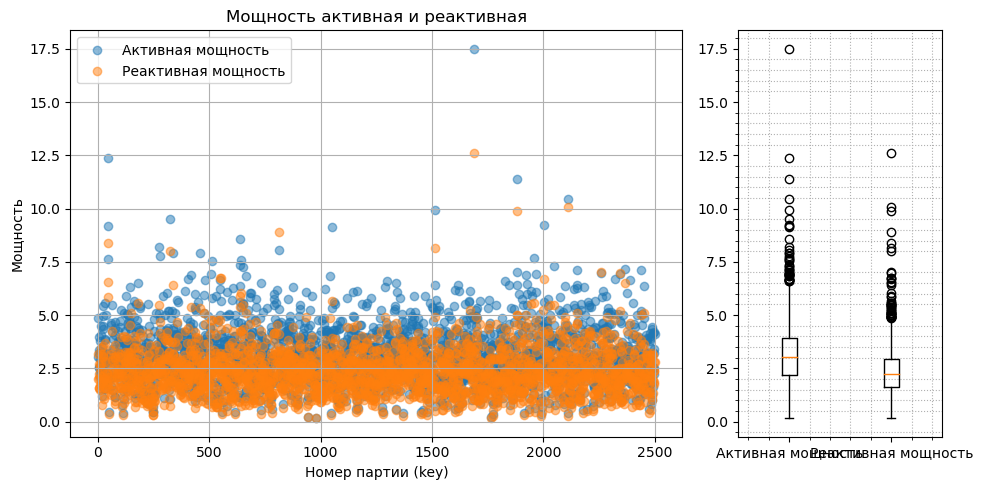

In [66]:
plot_scatter_box(df, ['Активная мощность','Реактивная мощность'], title='Мощность активная и реактивная', xlabel='Номер партии (key)', ylabel='Мощность')

Построим график по продувке сплава газом

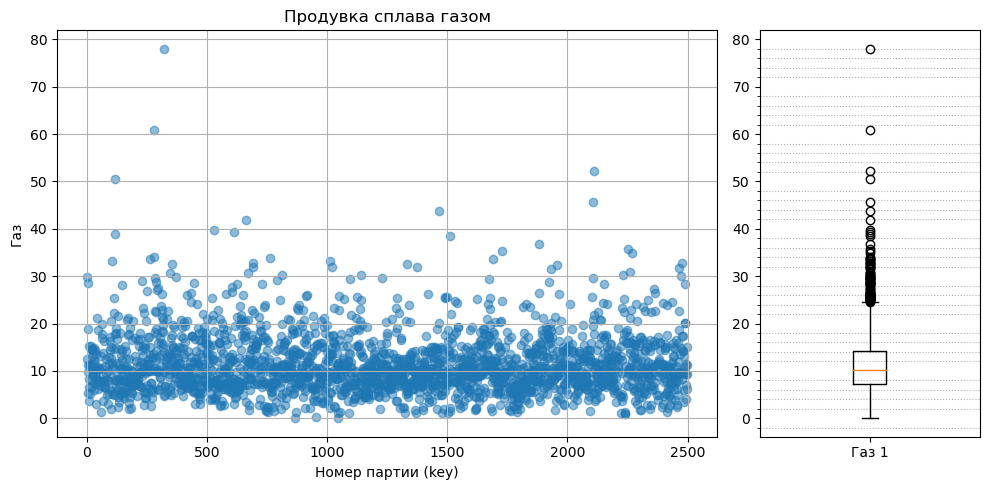

In [67]:
plot_scatter_box(df, ['Газ 1'], title='Продувка сплава газом', xlabel='Номер партии (key)', ylabel='Газ')

Построим распределение значений по материалам и газу

In [68]:
columns = [
    'Газ 1',
    'Wire 1',
    'Wire 2',
    'Bulk 1',
    'Bulk 3',
    'Bulk 4',
    'Bulk 6',
    'Bulk 10',
    'Bulk 11',
    'Bulk 12',
    'Bulk 14',
    'Bulk 15'
]

In [69]:
df[columns].describe()

Газ 1       Wire 1       Wire 2       Bulk 1       Bulk 3  \
count  2293.000000  2293.000000  2293.000000  2293.000000  2293.000000   
mean     11.398265   102.436703    17.710891     3.437854    47.646315   
std       6.400106    43.641875    33.798196    12.425773    75.544868   
min       0.008399     0.000000     0.000000     0.000000     0.000000   
25%       7.303306    73.207679     0.000000     0.000000     0.000000   
50%      10.108007   101.075520     0.000000     0.000000     0.000000   
75%      14.221584   128.069763    23.132721     0.000000    80.000000   
max      77.995040   330.314424   282.780152   185.000000   454.000000   

            Bulk 4       Bulk 6      Bulk 10      Bulk 11      Bulk 12  \
count  2293.000000  2293.000000  2293.000000  2293.000000  2293.000000   
mean     37.163977    22.575665     5.083733     4.147841   208.696031   
std      58.649208    56.076153    20.955637    22.258368   157.246962   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000   105.000000   
50%       0.000000     0.000000     0.000000     0.000000   206.000000   
75%      77.000000     0.000000     0.000000     0.000000   281.000000   
max     281.000000   503.000000   159.000000   313.000000  1849.000000   

           Bulk 14      Bulk 15  
count  2293.000000  2293.000000  
mean    154.081989   120.134758  
std      81.571328    84.726913  
min       0.000000     0.000000  
25%     105.000000     0.000000  
50%     149.000000   107.000000  
75%     204.000000   204.000000  
max     636.000000   405.000000

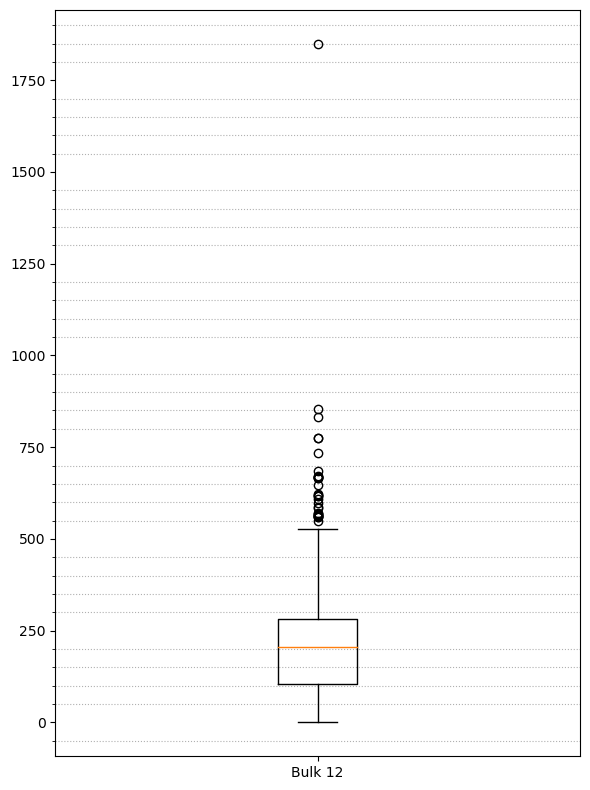

In [70]:
plt.figure(figsize=(6,8))
plt.boxplot(df['Bulk 12'].fillna(0), labels=['Bulk 12'])
plt.tight_layout()
plt.minorticks_on()
plt.grid(which='minor', linestyle=':')
plt.show()

Обратим внимание на выброс в данных о подаче сыпучих материалов

Проверим данные с помощью корреляции Пирсона

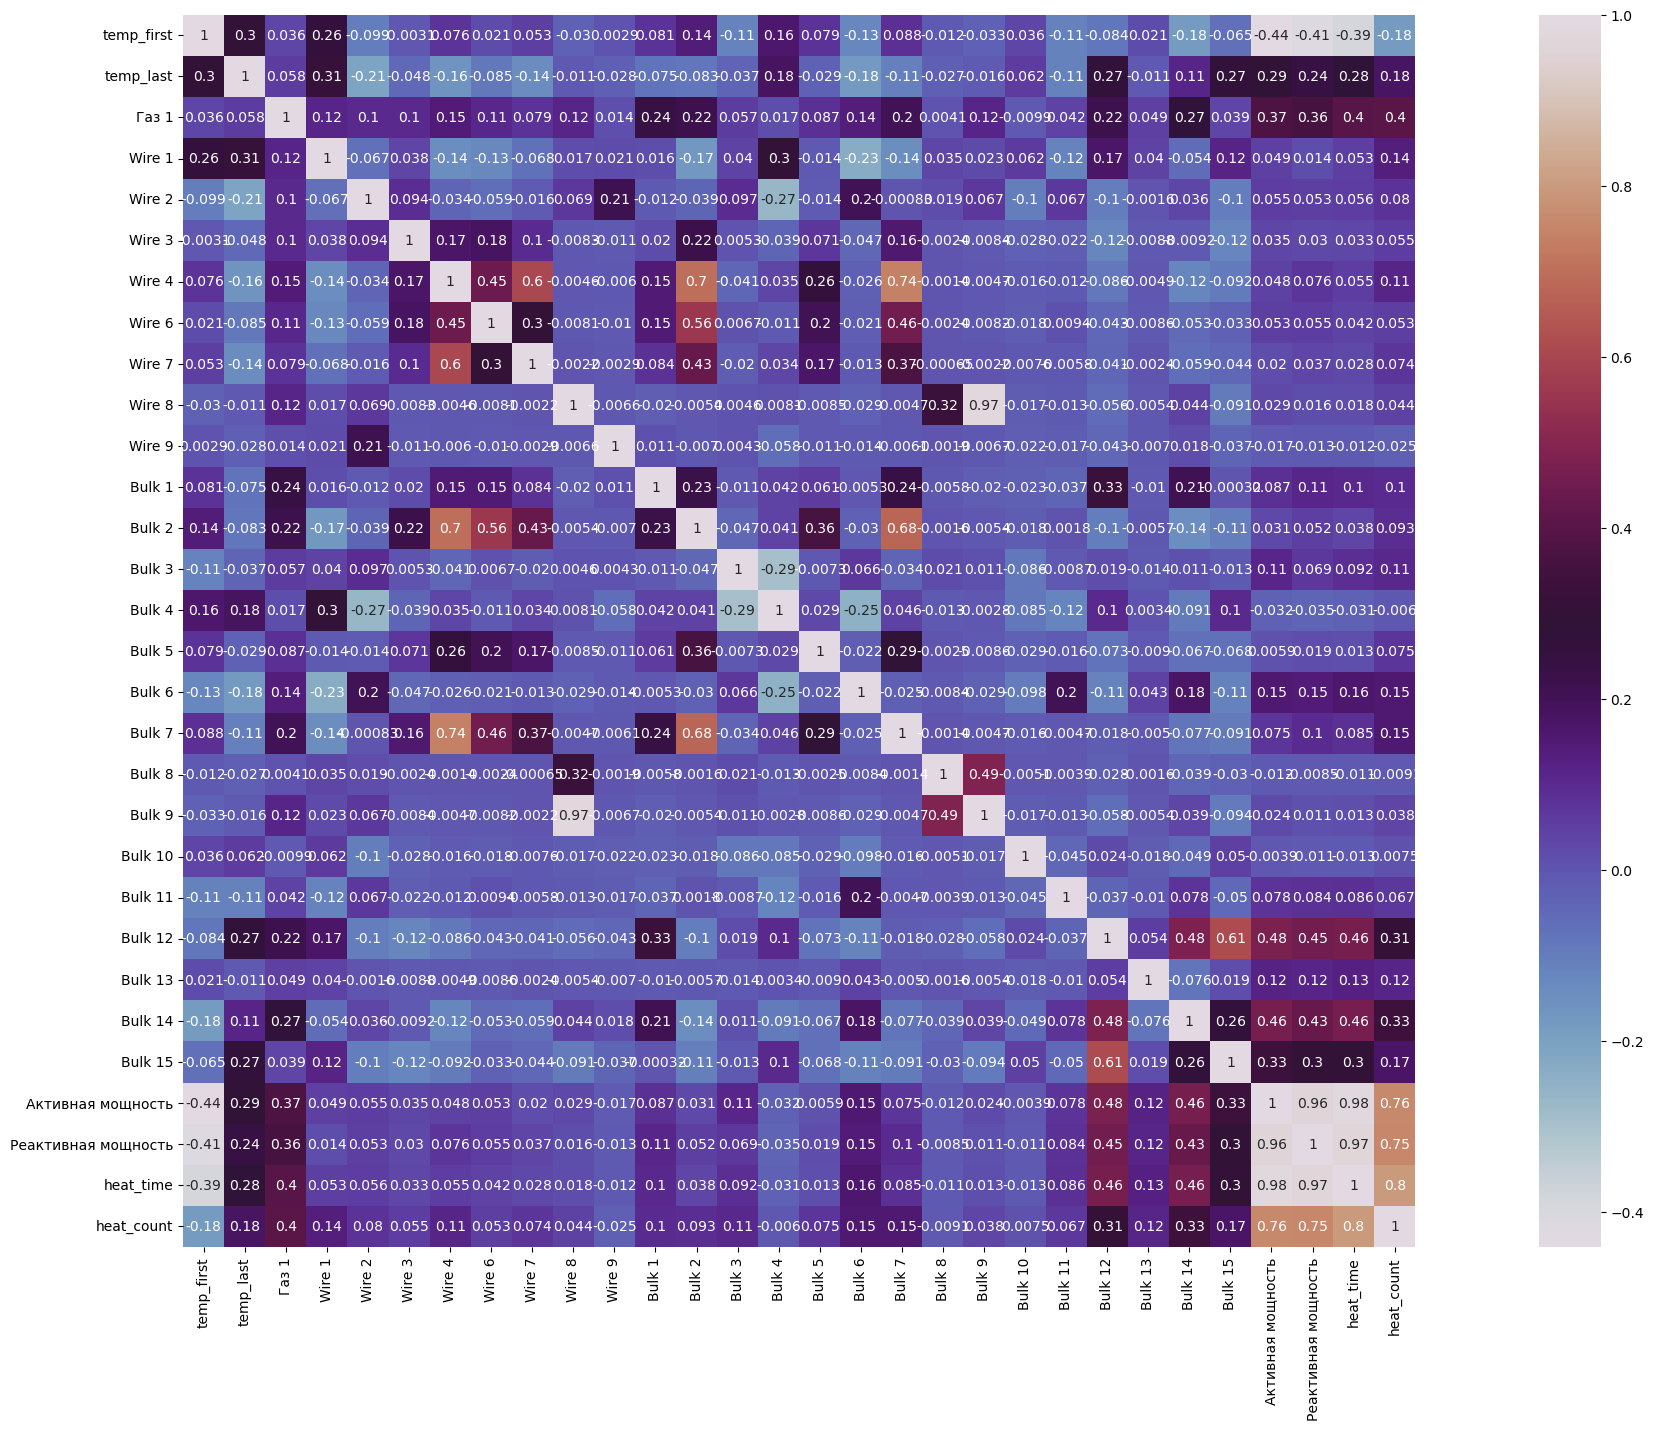

In [71]:
correlation = df_temp.corr()
plt.figure(figsize=(32,16))
sns.heatmap(correlation,vmax=1,square=True,annot=True,cmap='twilight')
plt.show()

Построим графики распределения и корреляции выбранных параметров

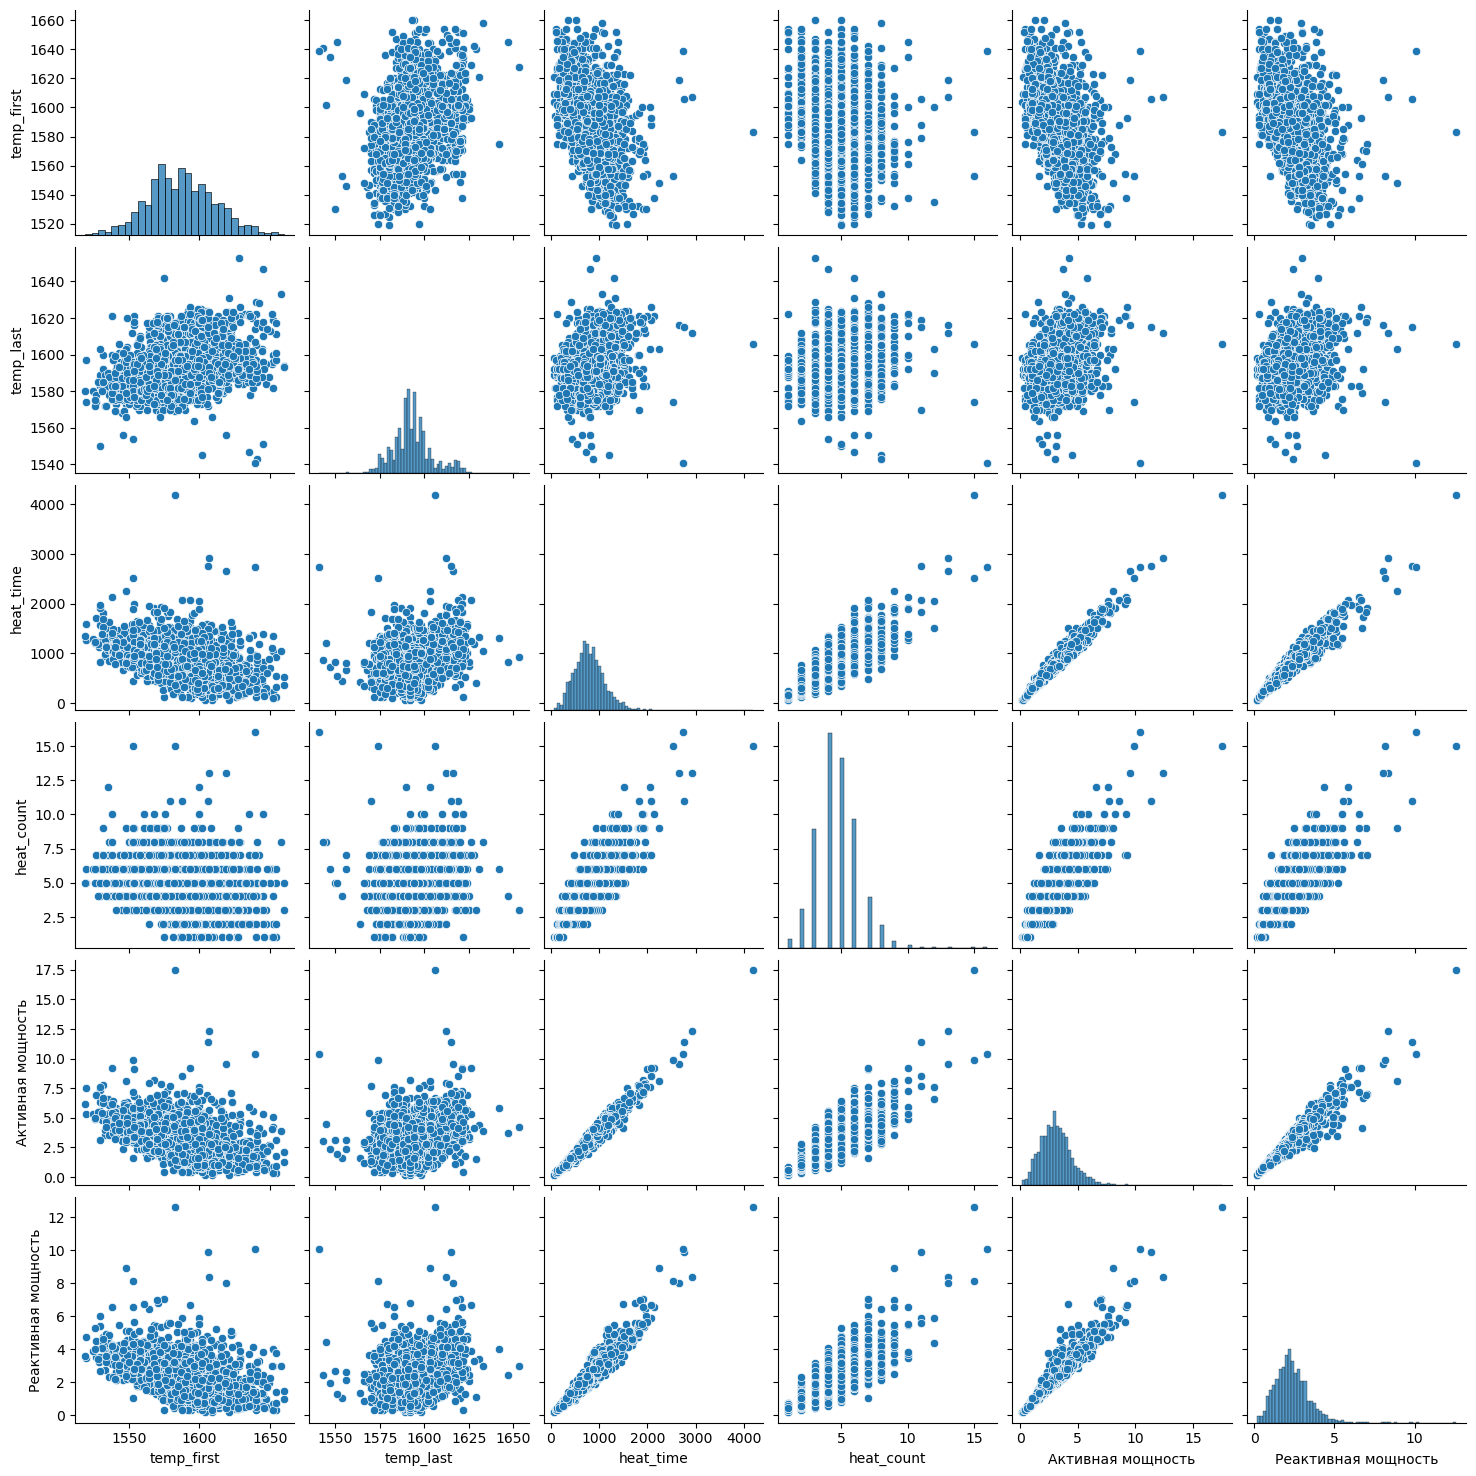

<Figure size 2000x2000 with 0 Axes>

In [72]:
sns.pairplot(df_temp[[
    'temp_first',
    'temp_last',
    'heat_time',
    'heat_count',
    'Активная мощность',
    'Реактивная мощность'
]])
plt.figure(figsize=(20,20))
plt.show()

Наблюдается линейная зависимость мощности и времени нагрева

### Вывод

- Для некоторых партий отстутствует информация о продувке газом
- Для некоторых партий отстутствует информация о добавлении сыпучих материалов
- Для некоторых партий отстутствует информация о добавлении проволочных материалов
- Данные содержат выбросы
- Аномальные данные о реактивной мощности были отсечены
- Отмечена выраженная линейная зависимость между временем нагрева, активной и реактивной мощностями
- Временные признаки не имеют прямого влияния на изменения данных

- Конечная температура нагрева имеет выраженную линейную зависимость от начальной температуры, активной мощности, реактивной мощности, времени нагрева и Wire 1

### Список вопросов

- Являются ли данные о замере температуры до начала нагрева адекватными?
- При использовании материалов, какие значения можно считать выбросами? 
- В качестве синтезированных признаков стоит использовать общую мощность или рассчитать энергию (мощность на дельту времени)? Возможно ли использование обоих параметров?
- Возможно ли исключить строки с отсутствующим значением/маленьким значением о добавлении сыпучих и проволочных материалов?
- Возможно ли использование в качестве заполнения пропусков в целевом признаке использовать значение-заглушку или заполенение пропусков нулем/медианой?

## Подготовка данных

### Определение призанков необходимых для обучения модели

Поскольку наблюдается выраженная линейная зависимость мощности и времени нагрева, введем дополнительные признаки для обучения модели.
Рассчитаем полную мощность, чтобы в дальнейшем иметь возможность расчитать энергию необходимую для нагрева.
Полная мощность расчитывается по формуле:

$$S=\sqrt{Q^2+P^2}$$

- S - полная мощность
- Q - активная мощность
- P - реактивная мощность

Так же, имея данные о полном времени нагрева мы можем рассчитать энергию, которая равно произведению мощности на время нагревания, по формуле:

$$ W = S * T $$

- W - энергия
- S - полная мощность
- T - общее время нагрева (столбец heat_time таблицы df_temp)

### Создание синтетических признаков при необходимости

In [73]:
df_temp['Полная мощность'] = (df_temp['Активная мощность'] ** 2 + df_temp['Реактивная мощность'] ** 2) ** (0.5)

In [74]:
df_temp['Энергия'] = df_temp['Полная мощность'] * df_temp['heat_time']

In [75]:
df_temp

time_first  temp_first           time_last  temp_last  \
key                                                                   
1    2019-05-03 11:16:18      1571.0 2019-05-03 11:30:39     1613.0   
2    2019-05-03 11:37:27      1581.0 2019-05-03 11:59:12     1602.0   
3    2019-05-03 12:13:17      1596.0 2019-05-03 12:34:57     1599.0   
4    2019-05-03 12:52:57      1601.0 2019-05-03 12:59:25     1625.0   
5    2019-05-03 13:23:19      1576.0 2019-05-03 13:36:01     1602.0   
...                  ...         ...                 ...        ...   
2495 2019-08-06 00:35:45      1570.0 2019-08-06 00:54:42     1591.0   
2496 2019-08-06 01:02:54      1554.0 2019-08-06 01:29:52     1591.0   
2497 2019-08-06 01:41:53      1571.0 2019-08-06 01:53:50     1589.0   
2498 2019-08-06 02:03:49      1591.0 2019-08-06 02:25:31     1594.0   
2499 2019-08-06 02:40:25      1569.0 2019-08-06 03:00:28     1603.0   

          Газ 1      Wire 1    Wire 2  Wire 3  Wire 4  Wire 6  ...  Bulk 12  \
key                                                            ...            
1     29.749986   60.059998   0.00000     0.0     0.0     0.0  ...    206.0   
2     12.555561   96.052315   0.00000     0.0     0.0     0.0  ...    206.0   
3     28.554793   91.160157   0.00000     0.0     0.0     0.0  ...    205.0   
4     18.841219   89.063515   0.00000     0.0     0.0     0.0  ...    207.0   
5      5.413692   89.238236   9.11456     0.0     0.0     0.0  ...    203.0   
...         ...         ...       ...     ...     ...     ...  ...      ...   
2495   7.125735   89.150879   0.00000     0.0     0.0     0.0  ...    256.0   
2496   9.412616  114.179527   0.00000     0.0     0.0     0.0  ...    256.0   
2497   6.271699   94.086723   9.04800     0.0     0.0     0.0  ...    230.0   
2498  14.953657  118.110717   0.00000     0.0     0.0     0.0  ...    206.0   
2499  11.336151  110.160958  50.00528     0.0     0.0     0.0  ...    233.0   

      Bulk 13  Bulk 14  Bulk 15  Активная мощность  Реактивная мощность  \
key                                                                       
1         0.0    150.0    154.0           4.878147             3.183241   
2         0.0    149.0    154.0           3.052598             1.998112   
3         0.0    152.0    153.0           2.525882             1.599076   
4         0.0    153.0    154.0           3.209250             2.060298   
5         0.0    151.0    152.0           3.347173             2.252643   
...       ...      ...      ...                ...                  ...   
2495      0.0    129.0    223.0           3.210690             2.360777   
2496      0.0    129.0    226.0           4.203064             2.810185   
2497      0.0    124.0    226.0           2.212379             1.851269   
2498      0.0    129.0    207.0           3.408725             2.355428   
2499      0.0    126.0    227.0           4.098431             2.777865   

      heat_time  heat_count  Полная мощность      Энергия  
key                                                        
1        1098.0           5         5.824889  6395.728622  
2         811.0           4         3.648398  2958.850582  
3         655.0           5         2.989502  1958.124109  
4         741.0           4         3.813674  2825.932742  
5         869.0           4         4.034596  3506.063873  
...         ...         ...              ...          ...  
2495      723.0           4         3.985197  2881.297646  
2496      940.0           6         5.055976  4752.617092  
2497      569.0           3         2.884756  1641.426283  
2498      750.0           5         4.143362  3107.521735  
2499      883.0           4         4.951128  4371.846122  

[2293 rows x 34 columns]

### Проведем проверку на корреляцию признаков

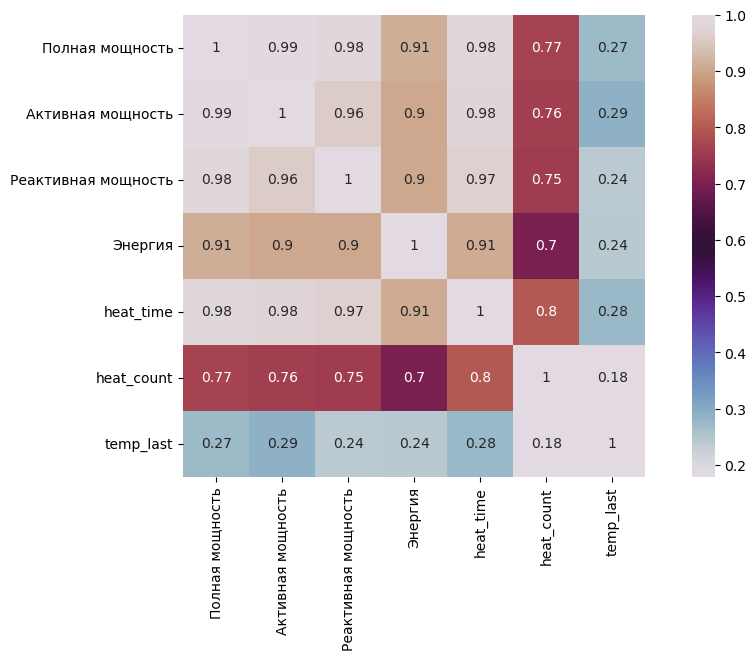

In [76]:
corr=df_temp[[
    'Полная мощность',
    'Активная мощность',
    'Реактивная мощность',
    'Энергия',
    'heat_time',
    'heat_count',
    'temp_last']].corr()
plt.figure(figsize=(12,6))
sns.heatmap(corr,vmax=1,square=True,annot=True,cmap='twilight')
plt.show()

Имеется выраженная корреляция между следующими признаками: 
- Полная мощность: heat_time, Энергия, Реактивная мощность, Активная мощность
- Активная мощность: heat_time, Энергия, Реактивная мощность, Полная мощность
- Реактивная мощность: heat_time, Энергия, Активная мощность, Полная мощность
- Энергия: heat_time, Реактивная мощность, Активная мощность, Полная мощность
Так же есть выраженная зависимость времени нагрева от количества нагревов, т.к. эти показатели связаны напрямую

### Удаление данных непригодных к обучению модели, заполнение пропусков


Уберем из таблицы признаки мощности, так как их значения учтены при расчете значения энергии

In [77]:
df_temp = df_temp.drop(['Полная мощность'], axis=1)
df_temp = df_temp.drop(['Реактивная мощность'], axis=1)
df_temp = df_temp.drop(['Активная мощность'], axis=1)

In [78]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 1 to 2499
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   time_first  2293 non-null   datetime64[ns]
 1   temp_first  2293 non-null   float64       
 2   time_last   2293 non-null   datetime64[ns]
 3   temp_last   2293 non-null   float64       
 4   Газ 1       2293 non-null   float64       
 5   Wire 1      2293 non-null   float64       
 6   Wire 2      2293 non-null   float64       
 7   Wire 3      2293 non-null   float64       
 8   Wire 4      2293 non-null   float64       
 9   Wire 6      2293 non-null   float64       
 10  Wire 7      2293 non-null   float64       
 11  Wire 8      2293 non-null   float64       
 12  Wire 9      2293 non-null   float64       
 13  Bulk 1      2293 non-null   float64       
 14  Bulk 2      2293 non-null   float64       
 15  Bulk 3      2293 non-null   float64       
 16  Bulk 4      2293 non-nul

In [81]:
df_temp

time_first  temp_first           time_last  temp_last  \
key                                                                   
1    2019-05-03 11:16:18      1571.0 2019-05-03 11:30:39     1613.0   
2    2019-05-03 11:37:27      1581.0 2019-05-03 11:59:12     1602.0   
3    2019-05-03 12:13:17      1596.0 2019-05-03 12:34:57     1599.0   
4    2019-05-03 12:52:57      1601.0 2019-05-03 12:59:25     1625.0   
5    2019-05-03 13:23:19      1576.0 2019-05-03 13:36:01     1602.0   
...                  ...         ...                 ...        ...   
2495 2019-08-06 00:35:45      1570.0 2019-08-06 00:54:42     1591.0   
2496 2019-08-06 01:02:54      1554.0 2019-08-06 01:29:52     1591.0   
2497 2019-08-06 01:41:53      1571.0 2019-08-06 01:53:50     1589.0   
2498 2019-08-06 02:03:49      1591.0 2019-08-06 02:25:31     1594.0   
2499 2019-08-06 02:40:25      1569.0 2019-08-06 03:00:28     1603.0   

          Газ 1      Wire 1    Wire 2  Wire 3  Wire 4  Wire 6  ...  Bulk 9  \
key                                                            ...           
1     29.749986   60.059998   0.00000     0.0     0.0     0.0  ...     0.0   
2     12.555561   96.052315   0.00000     0.0     0.0     0.0  ...     0.0   
3     28.554793   91.160157   0.00000     0.0     0.0     0.0  ...     0.0   
4     18.841219   89.063515   0.00000     0.0     0.0     0.0  ...     0.0   
5      5.413692   89.238236   9.11456     0.0     0.0     0.0  ...     0.0   
...         ...         ...       ...     ...     ...     ...  ...     ...   
2495   7.125735   89.150879   0.00000     0.0     0.0     0.0  ...     0.0   
2496   9.412616  114.179527   0.00000     0.0     0.0     0.0  ...     0.0   
2497   6.271699   94.086723   9.04800     0.0     0.0     0.0  ...     0.0   
2498  14.953657  118.110717   0.00000     0.0     0.0     0.0  ...     0.0   
2499  11.336151  110.160958  50.00528     0.0     0.0     0.0  ...     0.0   

      Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  heat_time  \
key                                                                     
1         0.0      0.0    206.0      0.0    150.0    154.0     1098.0   
2         0.0      0.0    206.0      0.0    149.0    154.0      811.0   
3         0.0      0.0    205.0      0.0    152.0    153.0      655.0   
4         0.0      0.0    207.0      0.0    153.0    154.0      741.0   
5         0.0      0.0    203.0      0.0    151.0    152.0      869.0   
...       ...      ...      ...      ...      ...      ...        ...   
2495     90.0      0.0    256.0      0.0    129.0    223.0      723.0   
2496    122.0      0.0    256.0      0.0    129.0    226.0      940.0   
2497      0.0      0.0    230.0      0.0    124.0    226.0      569.0   
2498    101.0      0.0    206.0      0.0    129.0    207.0      750.0   
2499      0.0      0.0    233.0      0.0    126.0    227.0      883.0   

      heat_count      Энергия  
key                            
1              5  6395.728622  
2              4  2958.850582  
3              5  1958.124109  
4              4  2825.932742  
5              4  3506.063873  
...          ...          ...  
2495           4  2881.297646  
2496           6  4752.617092  
2497           3  1641.426283  
2498           5  3107.521735  
2499           4  4371.846122  

[2293 rows x 31 columns]

In [82]:
df_temp.describe()

temp_first    temp_last        Газ 1       Wire 1       Wire 2  \
count  2293.000000  2293.000000  2293.000000  2293.000000  2293.000000   
mean   1587.296119  1593.369385    11.398265   102.436703    17.710891   
std      23.741904    11.179055     6.400106    43.641875    33.798196   
min    1519.000000  1541.000000     0.008399     0.000000     0.000000   
25%    1571.000000  1587.000000     7.303306    73.207679     0.000000   
50%    1587.000000  1593.000000    10.108007   101.075520     0.000000   
75%    1603.000000  1598.000000    14.221584   128.069763    23.132721   
max    1660.000000  1653.000000    77.995040   330.314424   282.780152   

            Wire 3       Wire 4       Wire 6       Wire 7       Wire 8  ...  \
count  2293.000000  2293.000000  2293.000000  2293.000000  2293.000000  ...   
mean      3.285578     0.311363     0.994187     0.006460     0.316199  ...   
std      28.158512     4.794808     8.760433     0.207313     4.436974  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
50%       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
75%       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
max     385.008668   113.231044   180.454575     8.490040   102.762401  ...   

            Bulk 9      Bulk 10      Bulk 11      Bulk 12      Bulk 13  \
count  2293.000000  2293.000000  2293.000000  2293.000000  2293.000000   
mean      0.451810     5.083733     4.147841   208.696031     1.084169   
std       6.269052    20.955637    22.258368   157.246962    14.345779   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000   105.000000     0.000000   
50%       0.000000     0.000000     0.000000   206.000000     0.000000   
75%       0.000000     0.000000     0.000000   281.000000     0.000000   
max     147.000000   159.000000   313.000000  1849.000000   305.000000   

           Bulk 14      Bulk 15    heat_time   heat_count       Энергия  
count  2293.000000  2293.000000  2293.000000  2293.000000   2293.000000  
mean    154.081989   120.134758   809.085478     4.699520   3789.837897  
std      81.571328    84.726913   341.310743     1.609848   3888.673837  
min       0.000000     0.000000    57.000000     1.000000     15.158096  
25%     105.000000     0.000000   585.000000     4.000000   1605.460193  
50%     149.000000   107.000000   780.000000     5.000000   2936.578826  
75%     204.000000   204.000000   995.000000     6.000000   4854.680685  
max     636.000000   405.000000  4189.000000    16.000000  90290.674886  

[8 rows x 29 columns]

## Подготовка признаков

Ввиду того, что данных немного выделение валидационной выборки нецелесообразно, сравнение результатов моделей будет пороводиться методом кросс-валидации.
Поскольку мы вычислили общее время нагрева, уберем колонки time_first и time_last

In [83]:
time_columns = ['time_first', 'time_last']
df_temp = df_temp.drop(time_columns, axis=1)

In [84]:
df_temp.head(5)

temp_first  temp_last      Газ 1     Wire 1   Wire 2  Wire 3  Wire 4  \
key                                                                         
1        1571.0     1613.0  29.749986  60.059998  0.00000     0.0     0.0   
2        1581.0     1602.0  12.555561  96.052315  0.00000     0.0     0.0   
3        1596.0     1599.0  28.554793  91.160157  0.00000     0.0     0.0   
4        1601.0     1625.0  18.841219  89.063515  0.00000     0.0     0.0   
5        1576.0     1602.0   5.413692  89.238236  9.11456     0.0     0.0   

     Wire 6  Wire 7  Wire 8  ...  Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  \
key                          ...                                               
1       0.0     0.0     0.0  ...     0.0      0.0      0.0    206.0      0.0   
2       0.0     0.0     0.0  ...     0.0      0.0      0.0    206.0      0.0   
3       0.0     0.0     0.0  ...     0.0      0.0      0.0    205.0      0.0   
4       0.0     0.0     0.0  ...     0.0      0.0      0.0    207.0      0.0   
5       0.0     0.0     0.0  ...     0.0      0.0      0.0    203.0      0.0   

     Bulk 14  Bulk 15  heat_time  heat_count      Энергия  
key                                                        
1      150.0    154.0     1098.0           5  6395.728622  
2      149.0    154.0      811.0           4  2958.850582  
3      152.0    153.0      655.0           5  1958.124109  
4      153.0    154.0      741.0           4  2825.932742  
5      151.0    152.0      869.0           4  3506.063873  

[5 rows x 29 columns]

In [85]:
X = df_temp.drop('temp_last', axis=1)
y = df_temp['temp_last']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=STATE)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1719, 28)
(1719,)
(574, 28)
(574,)


### Масштабирование данных

Поскольку некоторые из моделей чувствительны к значениям, масштабируем данные методом StandardScaler, так как техзадание не содержит иных требований к масштабированию.

In [86]:
sc = StandardScaler().fit(X_train)
X_train_sc = sc.transform(X_train)
X_test_sc = sc.transform(X_test)

### Обучение и сравнение моделей

Подбор гиперпараметров будет осуществляться с помощью кросс-валидации на пяти подвыборках

In [87]:
CVF = 5

Напишем функцию для сбора результатов обучения моделей в таблицу, для дальнейшего анализа

In [88]:
model_results = {'name': [], 'model': [], 'cv_mae': [], 'training_time': []}

def add_model_result(name, model, mae, time):
    model_results['name'].append(name)
    model_results['model'].append(model)
    model_results['cv_mae'].append(mae)
    if time:
        model_results['training_time'].append(time)

Напишем функцию для работы с GridSearch

In [89]:
def generate_clf(X, y, model, parameters):
    clf = GridSearchCV(model, parameters, cv=CVF, scoring='neg_mean_absolute_error', return_train_score=False, n_jobs=-1)
    clf.fit(X, y)
    return clf.best_estimator_, -clf.best_score_, clf
    print()

Зададим параметры для работы GridSearch

In [90]:
model_params = {
    'Desicion Tree': {
        'model': tree.DecisionTreeRegressor(criterion='mae', random_state=STATE), 
        'params' : {
            'max_depth': (5,6,7,8),
            'min_samples_leaf': range(2,7,2),
            'min_samples_split': range(3,8,2)
        }  
    },

    'Random Forest': {
        'model': ensemble.RandomForestRegressor(criterion='mae', n_jobs=-1, random_state=STATE),
        'params' : {
        'n_estimators': [200, 300],
        'max_depth': (6,8),
        'min_samples_leaf': (2,4),
        'min_samples_split': range(3,8,2)
       }  
   }, 
   

    'KNeighbors': {
        'model': KNeighborsRegressor(n_jobs=-1),
        'params' : {
            'n_neighbors': range(3,16,2),
            'leaf_size': (10, 30, 50),
            'algorithm': ('ball_tree', 'kd_tree', 'brute'),
            'p': (1, 2)
        }  
    }
}

Вычислим предсказание константной модели

In [92]:
start = time.time()

dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train_sc, y_train)
pred_dummy = dummy_regr.predict(X_test_sc)
mae_k = mean_absolute_error(y_test, pred_dummy)
add_model_result('k_mean', y_test.mean(), mae_k, time.time() - start)
print('Среднее константной модели')
print(f'MAE: {mae_k:.2f}')

Среднее константной модели
MAE: 8.15


Обучим модель линейной регрессии

In [93]:
start = time.time()

model_linear = linear_model.LinearRegression()

scores = cross_val_score(model_linear, X_train_sc, y_train, cv=CVF, scoring='neg_mean_absolute_error')
mae_linear = -scores.mean()

add_model_result('Linear', model_linear, mae_linear, time.time() - start)
print('Linear model')
print('MAE:', mae_linear)

Linear model
MAE: 6.915569092598966


Запустим GridSearch для подбора параметров для моделей Desicion Tree, Random Forest, KNN

In [94]:
for model_name, mp in model_params.items():
    print(model_name)
    start = time.time()
    model, mae, clf = generate_clf(X_train, y_train, mp['model'], mp['params'])
    add_model_result(model_name, model, mae, time.time() - start)
    print(f"Fit time: {(time.time() - start):.0f}s\n")

Desicion Tree
Fit time: 9s

Random Forest
Fit time: 312s

KNeighbors
Fit time: 2s



Обучим CatBoost

In [95]:
catboost_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'MAE',
    'iterations': 3000,
    'early_stopping_rounds': 50,
    'silent': True,
    'thread_count': -1,
    'random_seed': STATE
}

In [96]:
%%time

model = CatBoostRegressor(**catboost_params)

grid_catboost = {
        'learning_rate': [0.02, 0.05],
        'depth': [3, 4, 5],
        'l2_leaf_reg': [2, 3, 4]
        }

grid_search_result = model.grid_search(grid_catboost, 
                                       X=X_train, 
                                       y=y_train)

Stopped by overfitting detector  (50 iterations wait)

bestTest = 7.133764179
bestIteration = 567

0:	loss: 7.1337642	best: 7.1337642 (0)	total: 752ms	remaining: 12.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 7.632369868
bestIteration = 253

1:	loss: 7.6323699	best: 7.1337642 (0)	total: 1.04s	remaining: 8.34s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 7.404994446
bestIteration = 710

2:	loss: 7.4049944	best: 7.1337642 (0)	total: 1.73s	remaining: 8.67s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 7.600987565
bestIteration = 779

3:	loss: 7.6009876	best: 7.1337642 (0)	total: 2.48s	remaining: 8.69s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 7.650648948
bestIteration = 846

4:	loss: 7.6506489	best: 7.1337642 (0)	total: 3.29s	remaining: 8.55s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 7.644318724
bestIteration = 1035

5:	loss: 7.6443187	best: 7.1337642 (0)	total: 4.27s	remainin

In [97]:
start = time.time()
    
model_catboost = CatBoostRegressor(**grid_search_result['params'], **catboost_params)
model_catboost.fit(X_train, y_train)

scores = cross_val_score(model_catboost, X_train, y_train, cv=CVF, scoring='neg_mean_absolute_error')
mae_catboost = -scores.mean()

add_model_result('CatBoost', model_catboost, mae_catboost, time.time() - start)
print(f"Model: {grid_search_result['params']}")
print(f'MAE: {mae_catboost}')

Model: {'depth': 3, 'l2_leaf_reg': 2, 'learning_rate': 0.02}
MAE: 6.101155437004344


In [98]:
print(f"Model: {grid_search_result['params']}")
print(f'MAE: {mae_catboost}')

Model: {'depth': 3, 'l2_leaf_reg': 2, 'learning_rate': 0.02}
MAE: 6.101155437004344


Оценим результаты обучения моделей

In [99]:
df_results = pd.DataFrame(model_results)
df_results.sort_values('cv_mae')

name                                              model    cv_mae  \
5       CatBoost  <catboost.core.CatBoostRegressor object at 0x0...  6.101155   
3  Random Forest  (DecisionTreeRegressor(criterion='absolute_err...  6.183799   
1         Linear                                 LinearRegression()  6.915569   
2  Desicion Tree  DecisionTreeRegressor(criterion='mae', max_dep...  6.985484   
4     KNeighbors  KNeighborsRegressor(algorithm='ball_tree', lea...  7.631780   
0         k_mean                                        1593.055749  8.147300   

   training_time  
5      15.457670  
3     312.095296  
1       0.030882  
2       8.617491  
4       2.435441  
0       0.001000

Оценим влияние каждого из признаков на обучение модели

In [100]:
X_importance_df = pd.DataFrame(model_catboost.feature_importances_, index=X.columns)
X_importance_df.sort_values(0)

0
Bulk 8       0.000000
Wire 9       0.014297
Bulk 9       0.017744
Wire 8       0.030083
Bulk 13      0.094381
Wire 6       0.152496
Bulk 2       0.167484
Wire 4       0.283237
Wire 3       0.299049
Bulk 5       0.371596
Bulk 10      0.445287
Wire 7       1.039453
Bulk 11      1.060526
Bulk 4       1.687635
Bulk 3       1.741759
Bulk 1       2.452600
Bulk 7       2.772724
heat_count   3.265842
Bulk 15      3.473912
Bulk 12      3.535767
Bulk 14      3.577721
Газ 1        4.369437
Wire 2       5.034549
Bulk 6       5.335319
Wire 1       6.079486
heat_time    9.522286
Энергия     17.945336
temp_first  25.229997

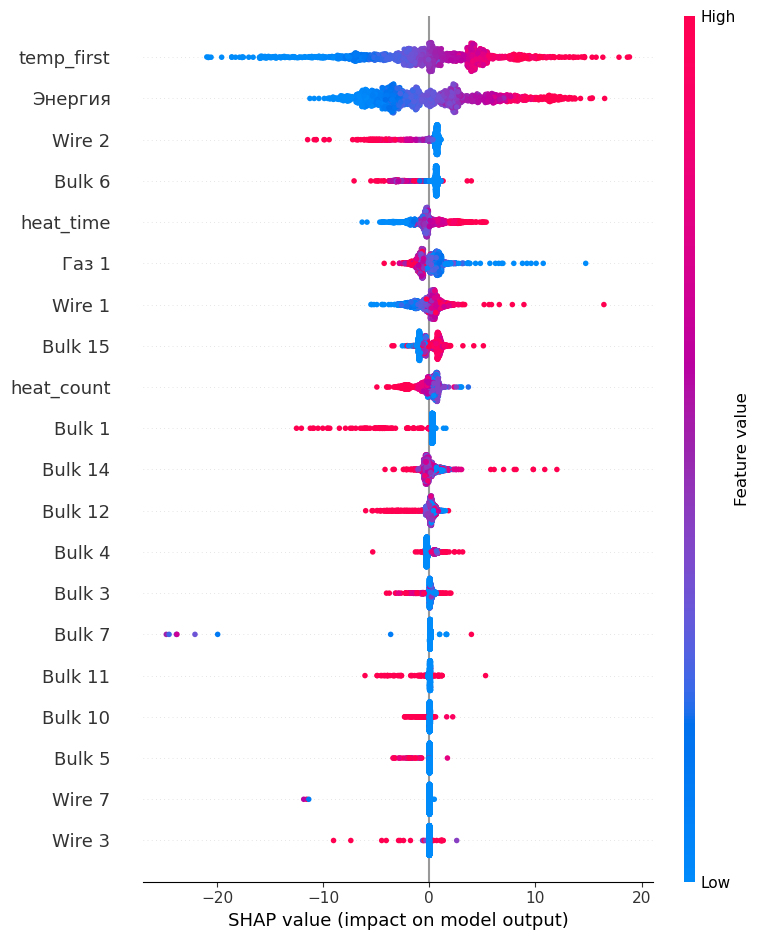

In [101]:
train_data = Pool(data=X_train,
                  label=y_train
                 )
                 
explainer = shap.TreeExplainer(model_catboost)
shap_values = explainer.shap_values(train_data) 
shap.summary_plot(shap_values, X_train, feature_names=X.columns.to_list())

Установлено назначительность некоторый параметров при обучении модели. По параметрам 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 13', 'Wire 3', 'Wire 4', 'Wire 7', 'Wire 8', 'Wire 9'  значений небольшое количество, исключим эти значения и сравним качество моделей.

Переобучим модели на обновленном наборе данных

In [102]:
df = df_temp.drop(['Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 13', 'Wire 3', 'Wire 4', 'Wire 7', 'Wire 8', 'Wire 9'], axis=1)

y = df['temp_last']
X = df.drop('temp_last', axis=1)

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.25, random_state=STATE)

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Обучим CatBoost

In [103]:
%%time
model = CatBoostRegressor(**catboost_params)

grid_search_result = model.grid_search(grid_catboost, 
                                       X=X_train, 
                                       y=y_train)

Stopped by overfitting detector  (50 iterations wait)

bestTest = 6.947379628
bestIteration = 1458

0:	loss: 6.9473796	best: 6.9473796 (0)	total: 1.33s	remaining: 22.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 7.207680029
bestIteration = 649

1:	loss: 7.2076800	best: 6.9473796 (0)	total: 1.95s	remaining: 15.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 7.186302393
bestIteration = 1537

2:	loss: 7.1863024	best: 6.9473796 (0)	total: 3.34s	remaining: 16.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 7.106199106
bestIteration = 1382

3:	loss: 7.1061991	best: 6.9473796 (0)	total: 4.6s	remaining: 16.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 7.159609943
bestIteration = 2453

4:	loss: 7.1596099	best: 6.9473796 (0)	total: 6.79s	remaining: 17.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 7.481416694
bestIteration = 1225

5:	loss: 7.4814167	best: 6.9473796 (0)	total: 7.91s	remai

In [104]:
start = time.time()
    
model_catboost = CatBoostRegressor(**grid_search_result['params'], **catboost_params)
model_catboost.fit(X_train, y_train)

scores = cross_val_score(model_catboost, X_train, y_train, cv=CVF, scoring='neg_mean_absolute_error')
mae_catboost = -scores.mean()

add_model_result('CatBoost_new', model_catboost, mae_catboost, time.time() - start)
print(f"Model: {grid_search_result['params']}")
print(f'MAE: {mae_catboost}')

Model: {'depth': 3, 'l2_leaf_reg': 2, 'learning_rate': 0.02}
MAE: 6.0780885789504


Оценим результат сокращения незначимых для обучения признаков:

In [105]:
X_importance_df = pd.DataFrame(model_catboost.feature_importances_, index=X.columns)
X_importance_df.sort_values(0)

0
Wire 6       0.191113
Bulk 2       0.230559
Bulk 5       0.465953
Bulk 11      1.072376
Bulk 4       1.499275
Bulk 3       1.861199
Bulk 1       2.618660
heat_count   3.522702
Bulk 12      3.839630
Bulk 14      3.866569
Bulk 15      3.874788
Bulk 7       4.037625
Газ 1        4.453963
Wire 2       4.965565
Bulk 6       5.557172
Wire 1       6.056499
heat_time   10.412509
Энергия     16.821237
temp_first  24.652607

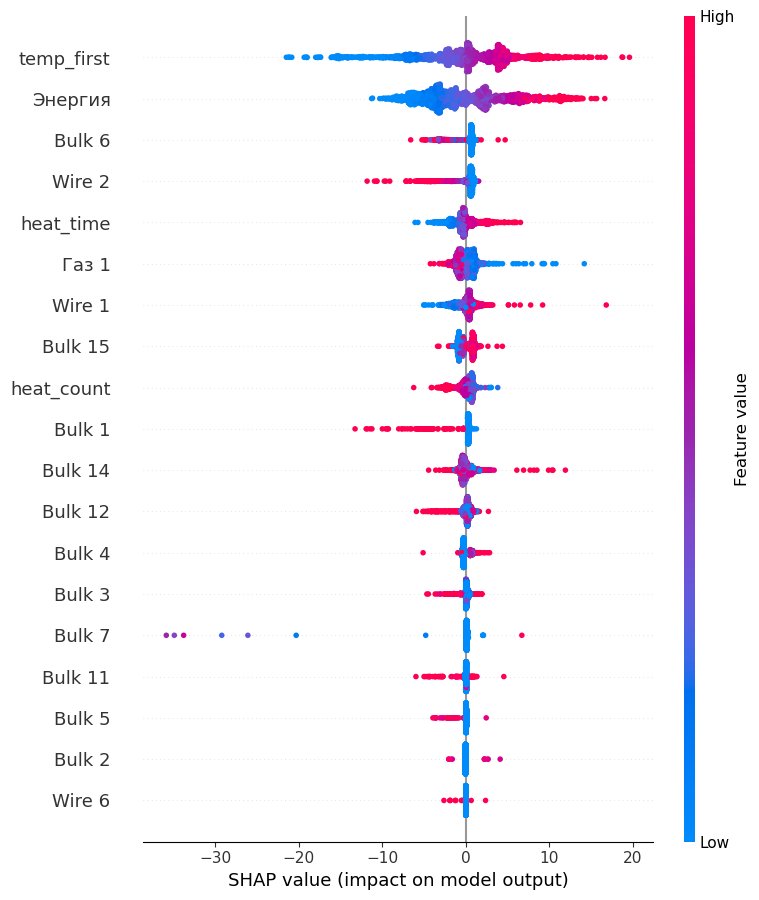

In [106]:
train_data = Pool(data=X_train,
                  label=y_train
                 )
                 
explainer = shap.TreeExplainer(model_catboost) 
shap_values = explainer.shap_values(train_data) 
shap.summary_plot(shap_values, X_train, feature_names=X.columns.to_list())

Переобучим остальные модели на обновленном наборе признаков

In [107]:
for model_name, mp in model_params.items():
    print(model_name)
    start = time.time()
    model, mae, clf = generate_clf(X_train, y_train, mp['model'], mp['params'])
    add_model_result(model_name, model, mae, time.time() - start)
    print(f"Fit time: {(time.time() - start):.0f}s\n")

Desicion Tree
Fit time: 4s

Random Forest
Fit time: 281s

KNeighbors
Fit time: 3s



Оценим результаты

In [108]:
df_results = pd.DataFrame(model_results)
df_results.sort_values('cv_mae')

name                                              model    cv_mae  \
6   CatBoost_new  <catboost.core.CatBoostRegressor object at 0x0...  6.078089   
5       CatBoost  <catboost.core.CatBoostRegressor object at 0x0...  6.101155   
8  Random Forest  (DecisionTreeRegressor(criterion='absolute_err...  6.183499   
3  Random Forest  (DecisionTreeRegressor(criterion='absolute_err...  6.183799   
9     KNeighbors  KNeighborsRegressor(algorithm='ball_tree', lea...  6.751734   
1         Linear                                 LinearRegression()  6.915569   
7  Desicion Tree  DecisionTreeRegressor(criterion='mae', max_dep...  6.968828   
2  Desicion Tree  DecisionTreeRegressor(criterion='mae', max_dep...  6.985484   
4     KNeighbors  KNeighborsRegressor(algorithm='ball_tree', lea...  7.631780   
0         k_mean                                        1593.055749  8.147300   

   training_time  
6      14.569748  
5      15.457670  
8     281.373497  
3     312.095296  
9       3.327752  
1       0.030882  
7       3.585886  
2       8.617491  
4       2.435441  
0       0.001000

### Вывод

- для подбора гиперпараметров использовали кросс-валидацию с разбивкой на 5 фолдов
- обучили разные модели и лучше всего себя показали Cat Boost и Случайный лес
- проанализировав значимость признаков избавились от признаков не значимых при обучении, что помогло улучшить результат Cat Boost и почти не сказалось на качестве модели Случайного леса

## Тестирование 

### Cat Boost

По результатам кросс-валидации лучший результат показала модель CatBoostRegressor, проведем тестирование для этой модели.

In [109]:
model = df_results[df_results['name']=='CatBoost_new'].iloc[0]['model']

predicted = model.predict(X_test)
test_mae_catboost = mean_absolute_error(y_test, predicted)
print(test_mae_catboost)

6.133085100719694


Цель исследования достигнута, лучшая модель, отобранная методом кросс-валидации на тестовых данных показала метрику MAE < 6.8

# Вывод

Был проведен разведывательный и исследовательский анализ данных, в результате которых в данных были выявлены выбросы и пропуски, изучено распределение данных, сформулированы дополнительные вопросы к заказчику исследования. В ходе работы были выделены признаки для обучения модели, кроме того, на основе предоставленных данных были сгенерированы синтетические признаки, оказавшиеся значительное влияние на обучение модели.

Было проведено обучение моделей: 
- CatBoost 
- Desicion Tree 
- Random Forest 
- Linear Regression

проведена проверка моделей на адекватность путем сравнения с предсказанием костантной модели, валидация проводилась методом кросс-валидации с пятью фолдами. 

Наилучший результат метрики MAE показала модель CatBoost, эта же модель была протестирована на тестовых данных.
MAE на тестовой выборке составила 6.13 тем самым, цель исследования достигнута.

В целях увеличения точности прогнозов вероятно следует отсекать данные о добавленных сыпучих и проволочных материалах, замере мощности нагрева, полученных хронологически после замерения конечной температуры.


# Отчет

## Какие пункты плана были выполнены, а какие — нет. Почему?

**Предобработка данных**

- *Выявление и работа с аномалиями в данных* - было выявлено некоторое количество выбросов в данных, большинство из них не потребовало дополнительной обработки ввиду их небольшого количества
- *Выявление и работа с ошибками в данных* - были выявлены и исключены из датасета строки содержащие не адекватные сведения, в в ходе проверки на адекватность данных
- *Выявление и обработка пропусков в данных* - пропуски в столбцах, содержащих информацию о добавлении сыпучих и проволочных материалов были заполнены нулевыми значениями, т.к. в процессе уточнения технического задания стало известно, что пропуск означает отсутствие подачи материалов в сплав.

**Подготовка данных**

- *Определение призанков необходимых для обучения модели* - был определен целевой признак для обучения модели - последняя температура нагрева
- *Создание синтетических признаков при необходимости* - было расчитано время нагрева и количество нагревов, так же на основании признаков "Активная мощность" и "Реактивная мощность" были расчитаны признаки "Полная мощность" и "Энергия"
- *Удаление данных непригодных к обучению модели при необходимости* - был удален признак не содержащий данных "Wire 5", а так же признаки Полная мощность, Реактивная мощность, Активная мощность - так как значения этих признаков были учтены при создании признака "Энергия"
- *Объединение данных в одну таблицу по полю key* - данные были объединены в итоговый датафрейм методом "inner", с полем 'key' установленным в качестве индекса.

**Подготовка признаков**

- *Выделение обучающего и целевого признака* - в качестве целевого признака была выделена последняя температура нагрева, в качестве обучающих данные о времени нагрева, количестве нагревов, энергии и данные о подаче сыпучих и проволочных материалов
- *Разделение данных на выборки обучающую и тестовую в формате 3:1* - данные были разделены на обучающую и тестовую выборку в нужной пропорции
- *Кодирование признаков при необходимости* - для обучения модели линейной регрессии данные были масштабированы с помощью StandartScaler

**Обучение модели**

- *Подбор гиперпараметров на разных моделях* - для подбора гиперпараметров модели были построены функции, внутри которых с помощью GridSearch были обучены разные модели - Решающее Дерево, Случайный лес, К-ближайшийх соседей, CatBoostRegressor, модель линейной регрессии
- *Выбор модели для проведения тестирования при помощи кросс-валидации* - ввиду малого количества данных валидационная выборка не выделялась, была проведена кросс-валидация с разделением на 5 фолдов, выбрана модель показавшая лучшую метрику
- *Проверка адекватности выбранной модели при помощи константной модели* - проверка адекватности модели при помощи константной модели была проведена с использованием DummyRegressor

Таким образом, можно заключить, что все пункты плана были выполнены

## Какие трудности возникли и как вы их преодолели?

- *Большое количество пропусков в данных о подаче сыпучих и проволочных материалов* - получено пояснение, пропуски заполненны нулевыми значениями
- *Наличие выбросов в каждом признаке* - получены пояснения, в большинстве случаев принято решение оставить без изменений
- *Недостаточность данных* - получены пояснения, создание синтетических признаков.

## Какие ключевые шаги в решении задачи вы выделили?

- Разведывательный анализ данных
- Предобработка данных
- Объединение данных в один датасет
- Подбор гиперпараметров для разных моделей
- Тестирование итоговой модели

## Какие признаки использовали для обучения модели и какая предобработка этих признаков была выполнена?

Были использованы признаки содержащие информацию
- о подаче сыпучих и проволочных материалов, удален столбец с нулевыми значениями
- Данные о продувке сплава газом - без изменений
- Время первого замера температуры - приведено к нужному типу
Были расчитаны признаки
- Количество нагревов
- Продолжительность нагревов
- Энергия

## Какая ваша итоговая модель, какие у неё гиперпараметы и какое качество?

Лучшая модель CatBoostRegressor c гиперпараметрами: {'depth': 3, 'l2_leaf_reg': 2, 'learning_rate': 0.02}, MAE на тестовой выборке составила 6.133085100719694